**Import Library**

In [1]:
# # Downgrade NumPy to latest 1.x version
# !pip install numpy==1.26.4 --force-reinstall

# # Reinstall dependencies
# !pip install scikit-learn-extra tslearn


# **Pre Processing**

In [2]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from scipy.interpolate import interp1d


## **Load Dataset & Data Correction**

In [3]:
# Upload the data data
df = pd.read_csv("august9th_dailysales (1).csv")

# Remove '|__' from all column names
df.columns = df.columns.str.replace(r'\|\_\_', '', regex=True)
df.rename(columns={'|': 'id'}, inplace=True)

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# List of columns to manually drop
columns_to_drop = ['customerNumber','year','total',
                   'Isoplus', 'Pisang G', 'Fanta', 'Nasi Pindang', 'Floridina', 'Coca-Cola', 'sosis 1rb ',
                   'Sosis Naget', 'Es Kopi Durian', 'Sereal', 'Frestea', 'Mie Ayam', 'NasBung A',
                   'Popmie', 'Teh Pucuk Harum', 'Milo', 'Siomay', 'Bakso', 'Es Buah', 'Es Dawet',
                   'Nasi Bungkus', 'Es Milo', 'Es Dawet Cincau', 'Mie Keriting', 'Seblak AsLi', 'Kuah Sop',
                   'SebLak Muzam', 'sebLak 375', 'Sebak 375', 'test', 'Test', 'Tes', 'Spaghetti',
                   'Es Cendol', 'Tahu Telur', 'Tahu Tek', 'Nasi Bungkus ', 'ES', 'tes', 'test2', 'Sop',
                   'Tahu Tek', 'Ayam Geprek (Tanpa Nasi)', 'Lele goreng', 'Ayam Geprek', 'voucher 15.000',
                   'cireng jumbo', 'Voucher Rp11000', 'ayam geprek', 'tahu ranjau', 'voucher 15000',
                   'jus mangga', 'sosis 1rb', '-', 'test minuman2', 'voucher 11000', 'Sprite', 'NasBung B',
                   'Test Food', 'test food', 'Tahu Tek ', 'Voucher', 'brengkesan pindang', 'Sosis 1rb ',
                   'timestamp___seconds', 'timestamp___nanoseconds', 'air gelas', 'Coca Cola Float',
                   'Risol Mayo', 'Kuah Sop ', 'Penyetan Ikan Asin', 'Pecel Tempe']  # Replace with actual column names

# Drop them from the DataFrame
df = df.drop(columns=columns_to_drop)

df.columns.tolist()

['id',
 'date',
 'Aqua',
 'Air Panas+gula',
 'tea float',
 'Orange Float',
 'Ayam Goreng',
 'Kopi Susu',
 'sosis goreng',
 'Nasi Telur ',
 'es batu',
 'Krupuk',
 'Kentang Goreng',
 'Teh Panas',
 'french fries ',
 'Nasi Goreng',
 'kerupuk udang',
 'tahu crispy',
 'telur mata sapi',
 'Sosis',
 'Telur Mata Sapi',
 'Club',
 'Nasi Telur',
 'Mie (Tanpa Telur)',
 'Ayam Silep (tanpa nasi)',
 'Nasi Sosis Goreng',
 'ayam silep',
 'month',
 'Aqua 600ml',
 'Kopi Hitam',
 'soto ayam',
 'gorengan',
 'nasi ayam silep',
 'Soto',
 'Masak Mie ',
 'Air Mineral',
 'Kerupuk ',
 'Es Krim',
 'Jeruk Hangat',
 'Kerupuk',
 'Sayur Asem Tempe Goreng',
 'Es Chocolatos',
 'Nasi Putih ',
 'Nasi Sosis',
 'Tahu Krispy',
 'Sayur Asem Lele',
 'soto',
 'Masak Mie',
 'Sosis 1rb',
 'Es Salju',
 'Nasi Ayam',
 'Kentang G',
 'Tahu G',
 'Cireng isi',
 'Mie',
 'Penyetan Dadar',
 'Coffee Float',
 'Sayur Sop Tempe Goreng',
 'Sayur Sop Ayam Goreng',
 'Aneka Kopi',
 'Cireng Isi',
 'Masak Mie+Telur',
 'Penyetan Telur ',
 'Penyetan L

## **Add day names**

In [4]:
# # Define the date range
# start_date = "2022-02-21"
# end_date = "2024-12-29"

# # Filter the dataframe based on the date range
# df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [5]:
# Add a new column for the day of the week
df['date'].dt.day_name()

0        Thursday
1        Saturday
2          Sunday
3          Monday
4         Tuesday
          ...    
1039      Tuesday
1040    Wednesday
1041     Thursday
1042       Friday
1043     Saturday
Name: date, Length: 1044, dtype: object

## **Merge Duplicate Columns**

In [6]:
# Define groups of duplicate columns to merge
column_merges = {
    'Mie (Tanpa Telur)': ['Mie (Tanpa Telur)', 'Masak Mie ', 'Masak Mie', 'masak mie', 'mie tanpa telur', 'Mie Tanpa Telur'],
    'Tahu Krispy': ['Tahu Krispy', 'tahu crispy', 'Tahu G'],
    'Nasi Goreng': ['Nasi Goreng', 'nasi goreng'],
    'French Fries': ['Kentang Goreng', 'french fries ', 'Kentang G', 'French Fries'],
    'Nasi Ayam Silep': ['Ayam Silep', 'nasi ayam silep', 'ayam silep'],
    'Soto Ayam': ['soto ayam', 'Soto', 'soto'],
    'Telur Mata Sapi': ['telur mata sapi', 'Telur Mata Sapi', 'Telor Matasapi'],
    'Nasi Telur': ['nasi telur', 'Nasi Telur', 'Nasi Telur '],
    'Cireng Isi': ['Cireng isi', 'cireng ', 'cireng isi', 'Cireng Isi'],
    'Sosis Goreng': ['sosis goreng', 'Sosis Goreng', 'Sosis', 'Sosis 1rb', 'sosis'],
    'Mie': ['Mie', 'Masak Mie + Telur', 'mie', 'masak mie+telur', 'Masak Mie+Telur'],
    'Nasi Sosis Goreng': ['nasi sosis goreng ', 'Nasi Sosis Goreng'],
    'Gorengan': ['gorengan', 'Gorengan ', 'Gorengan'],
    'Ayam Silep (Tanpa Nasi)' : ['Ayam Silep (tanpa nasi)', 'ayam silep (tanpa nasi)', 'Ayam Silep (Tanpa nasi)'],
    'Nasi Putih': ['Nasi Putih', 'nasi putih', 'Nasi Putih '],
    'Nasi Goreng': ['Nasi Goreng', 'nasi goreng'],
    'Air Putih': ['Aqua 600ml', 'Air Mineral', 'Club', 'Aqua'],
    'Slushy': ['Es Salju', 'Es Salju (Slushy)'],
    'Teh Panas': ['Teh Panas', 'Teh Hangat'],
    'Es Batu': ['Es Batu', 'es batu'],
    'Air Panas': ['Air Panas', 'Es Batu/air panas', 'Air Panas+gula'],
    'Kuah Sop': ['Kuah Sop ', 'Kuah Sop'],
    'Kerupuk': ['Krupuk','Kerupuk ','Kerupuk', 'kerupuk udang'],
    'Es Krim': ['Es Krim', 'Es krim'],
    'Jeruk Hangat': ['Jeruk Hangat', 'jeruk hangat'],
    'Sayur Asem Lele': ['Sayur Asem Lele', 'sayur Asem lele'],
    'Sayur Asem Tempe': ['Sayur Sop Tempe Goreng', 'Sayur Asem Tempe Goreng'],
    'Sayur Asem Telur': ['Sayur Sop Telur Goreng', 'Sayur Asem Telur Goreng'],
    'Sayur Asem Ayam': ['Sayur Asem Ayam Goreng', 'Sayur Sop Ayam Goreng'],
    'Penyetan Telur': ['Penyetan Telur ', 'Penyetan Dadar'],
    'Penyetan Lele': ['Penyetan Lele', 'penyetan lele'],
    'Kopi' : ['Es Kopi', 'Es Kopi/chocolatos', 'Kopi Hitam', 'Aneka Kopi', 'Kopi Susu', 'Es Chocolatos'],
    'Float': ['Coffee Float', 'Tea Float', 'Orange Float', 'Chocolatos Float', 'tea float', 'Tea Float'],
    'Teh': ['Teh', 'Teh Panas'],
}

# Merge duplicate columns with correct row count handling
for new_column, old_columns in column_merges.items():
    existing_columns = [col for col in old_columns if col in df.columns]

    if existing_columns:  # Only merge if at least one of the columns exists
        # Sum values across duplicates
        df[new_column] = df[existing_columns].sum(axis=1, skipna=True)

        # Identify rows where all duplicates were NaN
        df[new_column] = df[new_column].where(df[existing_columns].notna().any(axis=1), other=pd.NA)

        # Drop only the old duplicate columns, keeping the new merged one
        existing_columns = [col for col in existing_columns if col != new_column]
        df.drop(columns=existing_columns, inplace=True)

# **Convert categorical columns to string before replacing NaN**
for col in df.select_dtypes(['category']).columns:
    df[col] = df[col].astype(str)

# **Standardize missing values: Replace all NaN with 0**
df.fillna(0, inplace=True)

# Display updated columns to confirm merging of duplicates
print("Updated Columns After Merging:")
df.columns.tolist()

Updated Columns After Merging:


['id',
 'date',
 'Ayam Goreng',
 'Nasi Goreng',
 'Telur Mata Sapi',
 'Nasi Telur',
 'Mie (Tanpa Telur)',
 'Nasi Sosis Goreng',
 'month',
 'Es Krim',
 'Jeruk Hangat',
 'Kerupuk',
 'Nasi Sosis',
 'Tahu Krispy',
 'Sayur Asem Lele',
 'Nasi Ayam',
 'Mie',
 'Cireng Isi',
 'Penyetan Lele',
 'Penyetan Ayam ',
 'Es Teh',
 'Es Batu',
 'Nasi Putih',
 'Penyetan Tempe',
 'Air Panas',
 'Es Jeruk',
 'French Fries',
 'Pisang Coklat Keju',
 'Chocolatos Panas',
 'Sosis Goreng',
 'Gorengan',
 'Sayur Asem Dadar',
 'Nasi Ayam Silep',
 'Soto Ayam',
 'Ayam Silep (Tanpa Nasi)',
 'Air Putih',
 'Slushy',
 'Sayur Asem Tempe',
 'Sayur Asem Telur',
 'Sayur Asem Ayam',
 'Penyetan Telur',
 'Kopi',
 'Float',
 'Teh']

In [7]:
# Define groups of duplicate columns to merge
column_merges = {'Misc': ['Es Batu', 'Jeruk Hangat', 'Kerupuk', 'Air Panas', 'Chocolatos Panas', 'Nasi Putih', 'Ayam Goreng', 'Ayam Silep (Tanpa Nasi)', 'Nasi Ayam'],
                 'Penyetan Telur': ['Penyetan Telur', 'Penyetan Dadar'],
                 'Sosis': ['Nasi Sosis Goreng', 'Nasi Sosis', 'Sosis Goreng']}

# Merge duplicate columns with correct row count handling
for new_column, old_columns in column_merges.items():
    existing_columns = [col for col in old_columns if col in df.columns]

    if existing_columns:  # Only merge if at least one of the columns exists
        # Sum values across duplicates
        df[new_column] = df[existing_columns].sum(axis=1, skipna=True)

        # Identify rows where all duplicates were NaN
        df[new_column] = df[new_column].where(df[existing_columns].notna().any(axis=1), other=pd.NA)

        # Drop only the old duplicate columns, keeping the new merged one
        existing_columns = [col for col in existing_columns if col != new_column]
        df.drop(columns=existing_columns, inplace=True)

# **Convert categorical columns to string before replacing NaN**
for col in df.select_dtypes(['category']).columns:
    df[col] = df[col].astype(str)

# **Standardize missing values: Replace all NaN with 0**
df.fillna(0, inplace=True)

# Display updated columns to confirm merging of duplicates
print("Updated Columns After Merging:")
df.columns.tolist()

Updated Columns After Merging:


['id',
 'date',
 'Nasi Goreng',
 'Telur Mata Sapi',
 'Nasi Telur',
 'Mie (Tanpa Telur)',
 'month',
 'Es Krim',
 'Tahu Krispy',
 'Sayur Asem Lele',
 'Mie',
 'Cireng Isi',
 'Penyetan Lele',
 'Penyetan Ayam ',
 'Es Teh',
 'Penyetan Tempe',
 'Es Jeruk',
 'French Fries',
 'Pisang Coklat Keju',
 'Gorengan',
 'Sayur Asem Dadar',
 'Nasi Ayam Silep',
 'Soto Ayam',
 'Air Putih',
 'Slushy',
 'Sayur Asem Tempe',
 'Sayur Asem Telur',
 'Sayur Asem Ayam',
 'Penyetan Telur',
 'Kopi',
 'Float',
 'Teh',
 'Misc',
 'Sosis']

In [8]:
# df = df.drop(columns=['Orange Float', 'Nasi Telur','Chocolatos Panas','Masak Mie+Telur',
#                       'month','Slushy','Masak Mie', 'Nasi Sosis','Nasi Goreng','Air Panas',
#                       'Es Batu'])

In [9]:
df.to_excel('df.xlsx', index=False)

# **Exploratory Data Analysis**

## **Plotting All Items Together**

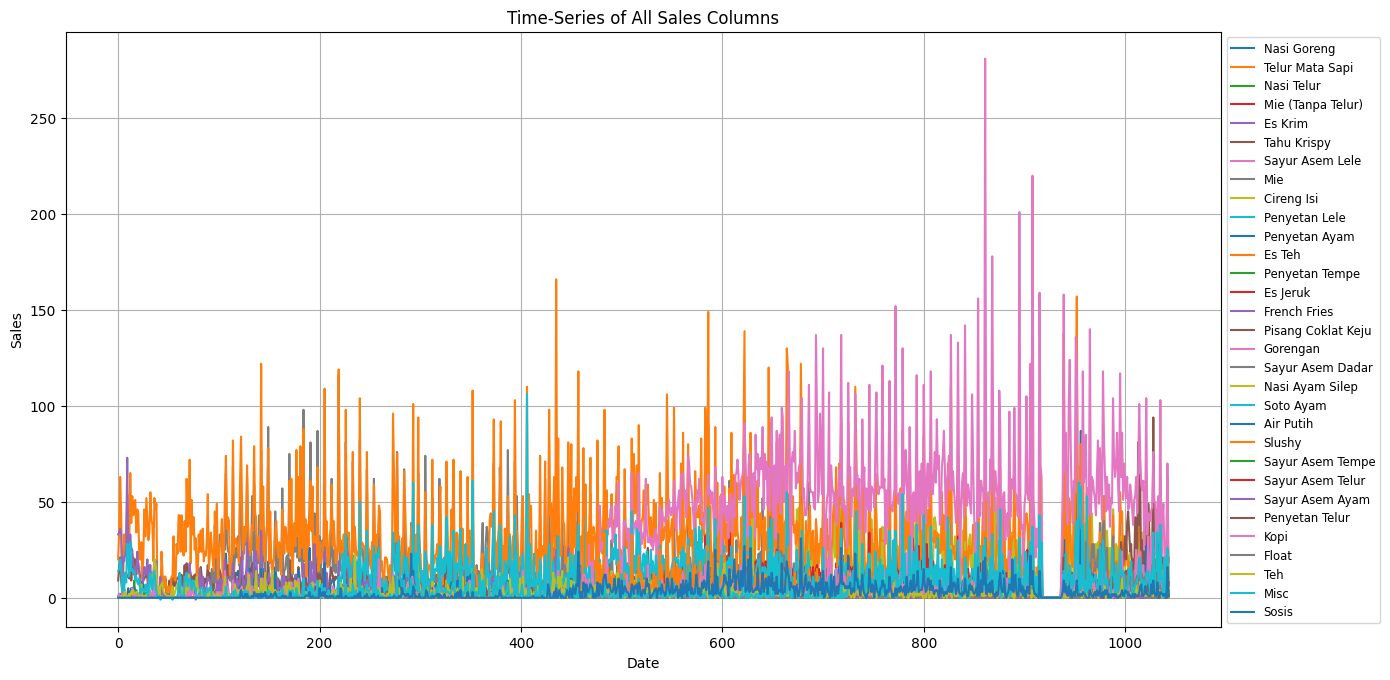

In [10]:
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Plot each numeric column as a separate time-series line
plt.figure(figsize=(14, 7))
for col in numeric_cols:
    plt.plot(df.index, df[col], label=col)

# Customize the plot
plt.title("Time-Series of All Sales Columns")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Min Max Scaler**

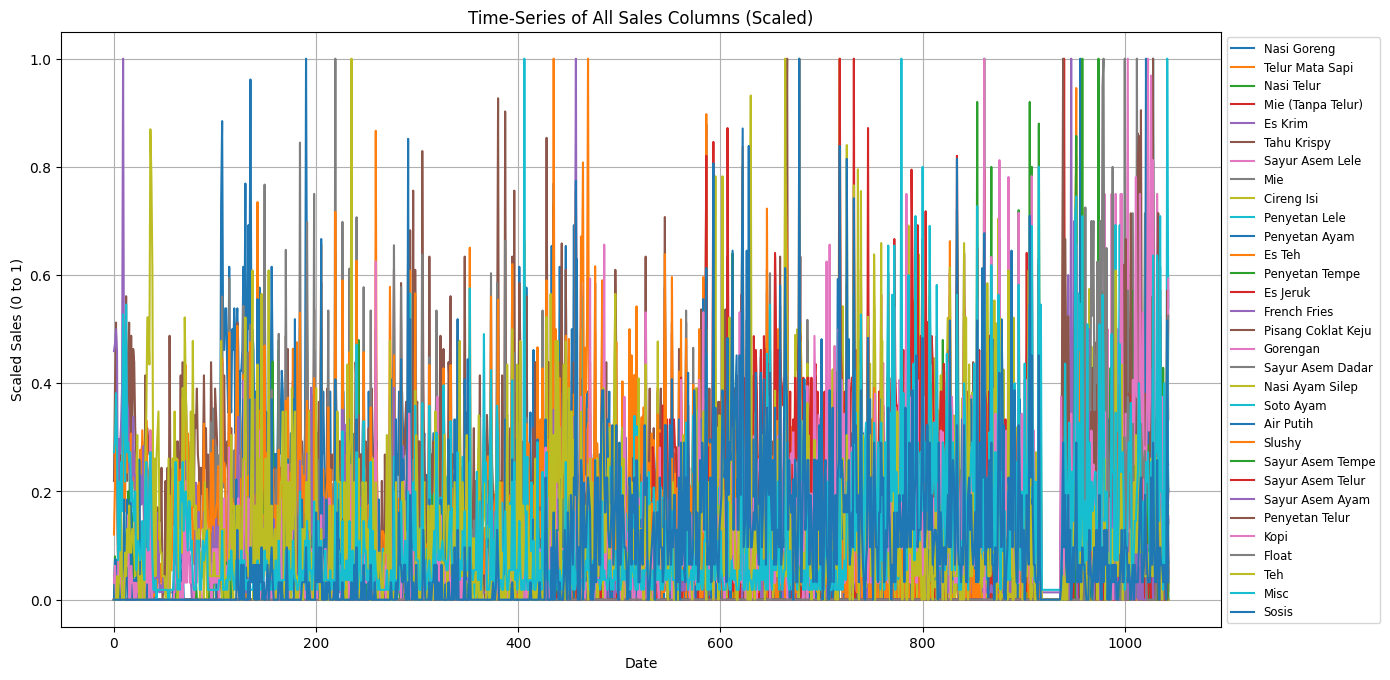

In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Apply Min-Max scaling to bring all values to [0, 1]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_cols]),
                         columns=numeric_cols,
                         index=df.index)

# Plot each scaled numeric column as a separate time-series line
plt.figure(figsize=(14, 7))
for col in numeric_cols:
    plt.plot(df_scaled.index, df_scaled[col], label=col)

# Customize the plot
plt.title("Time-Series of All Sales Columns (Scaled)")
plt.xlabel("Date")
plt.ylabel("Scaled Sales (0 to 1)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

## **zscore scaler**

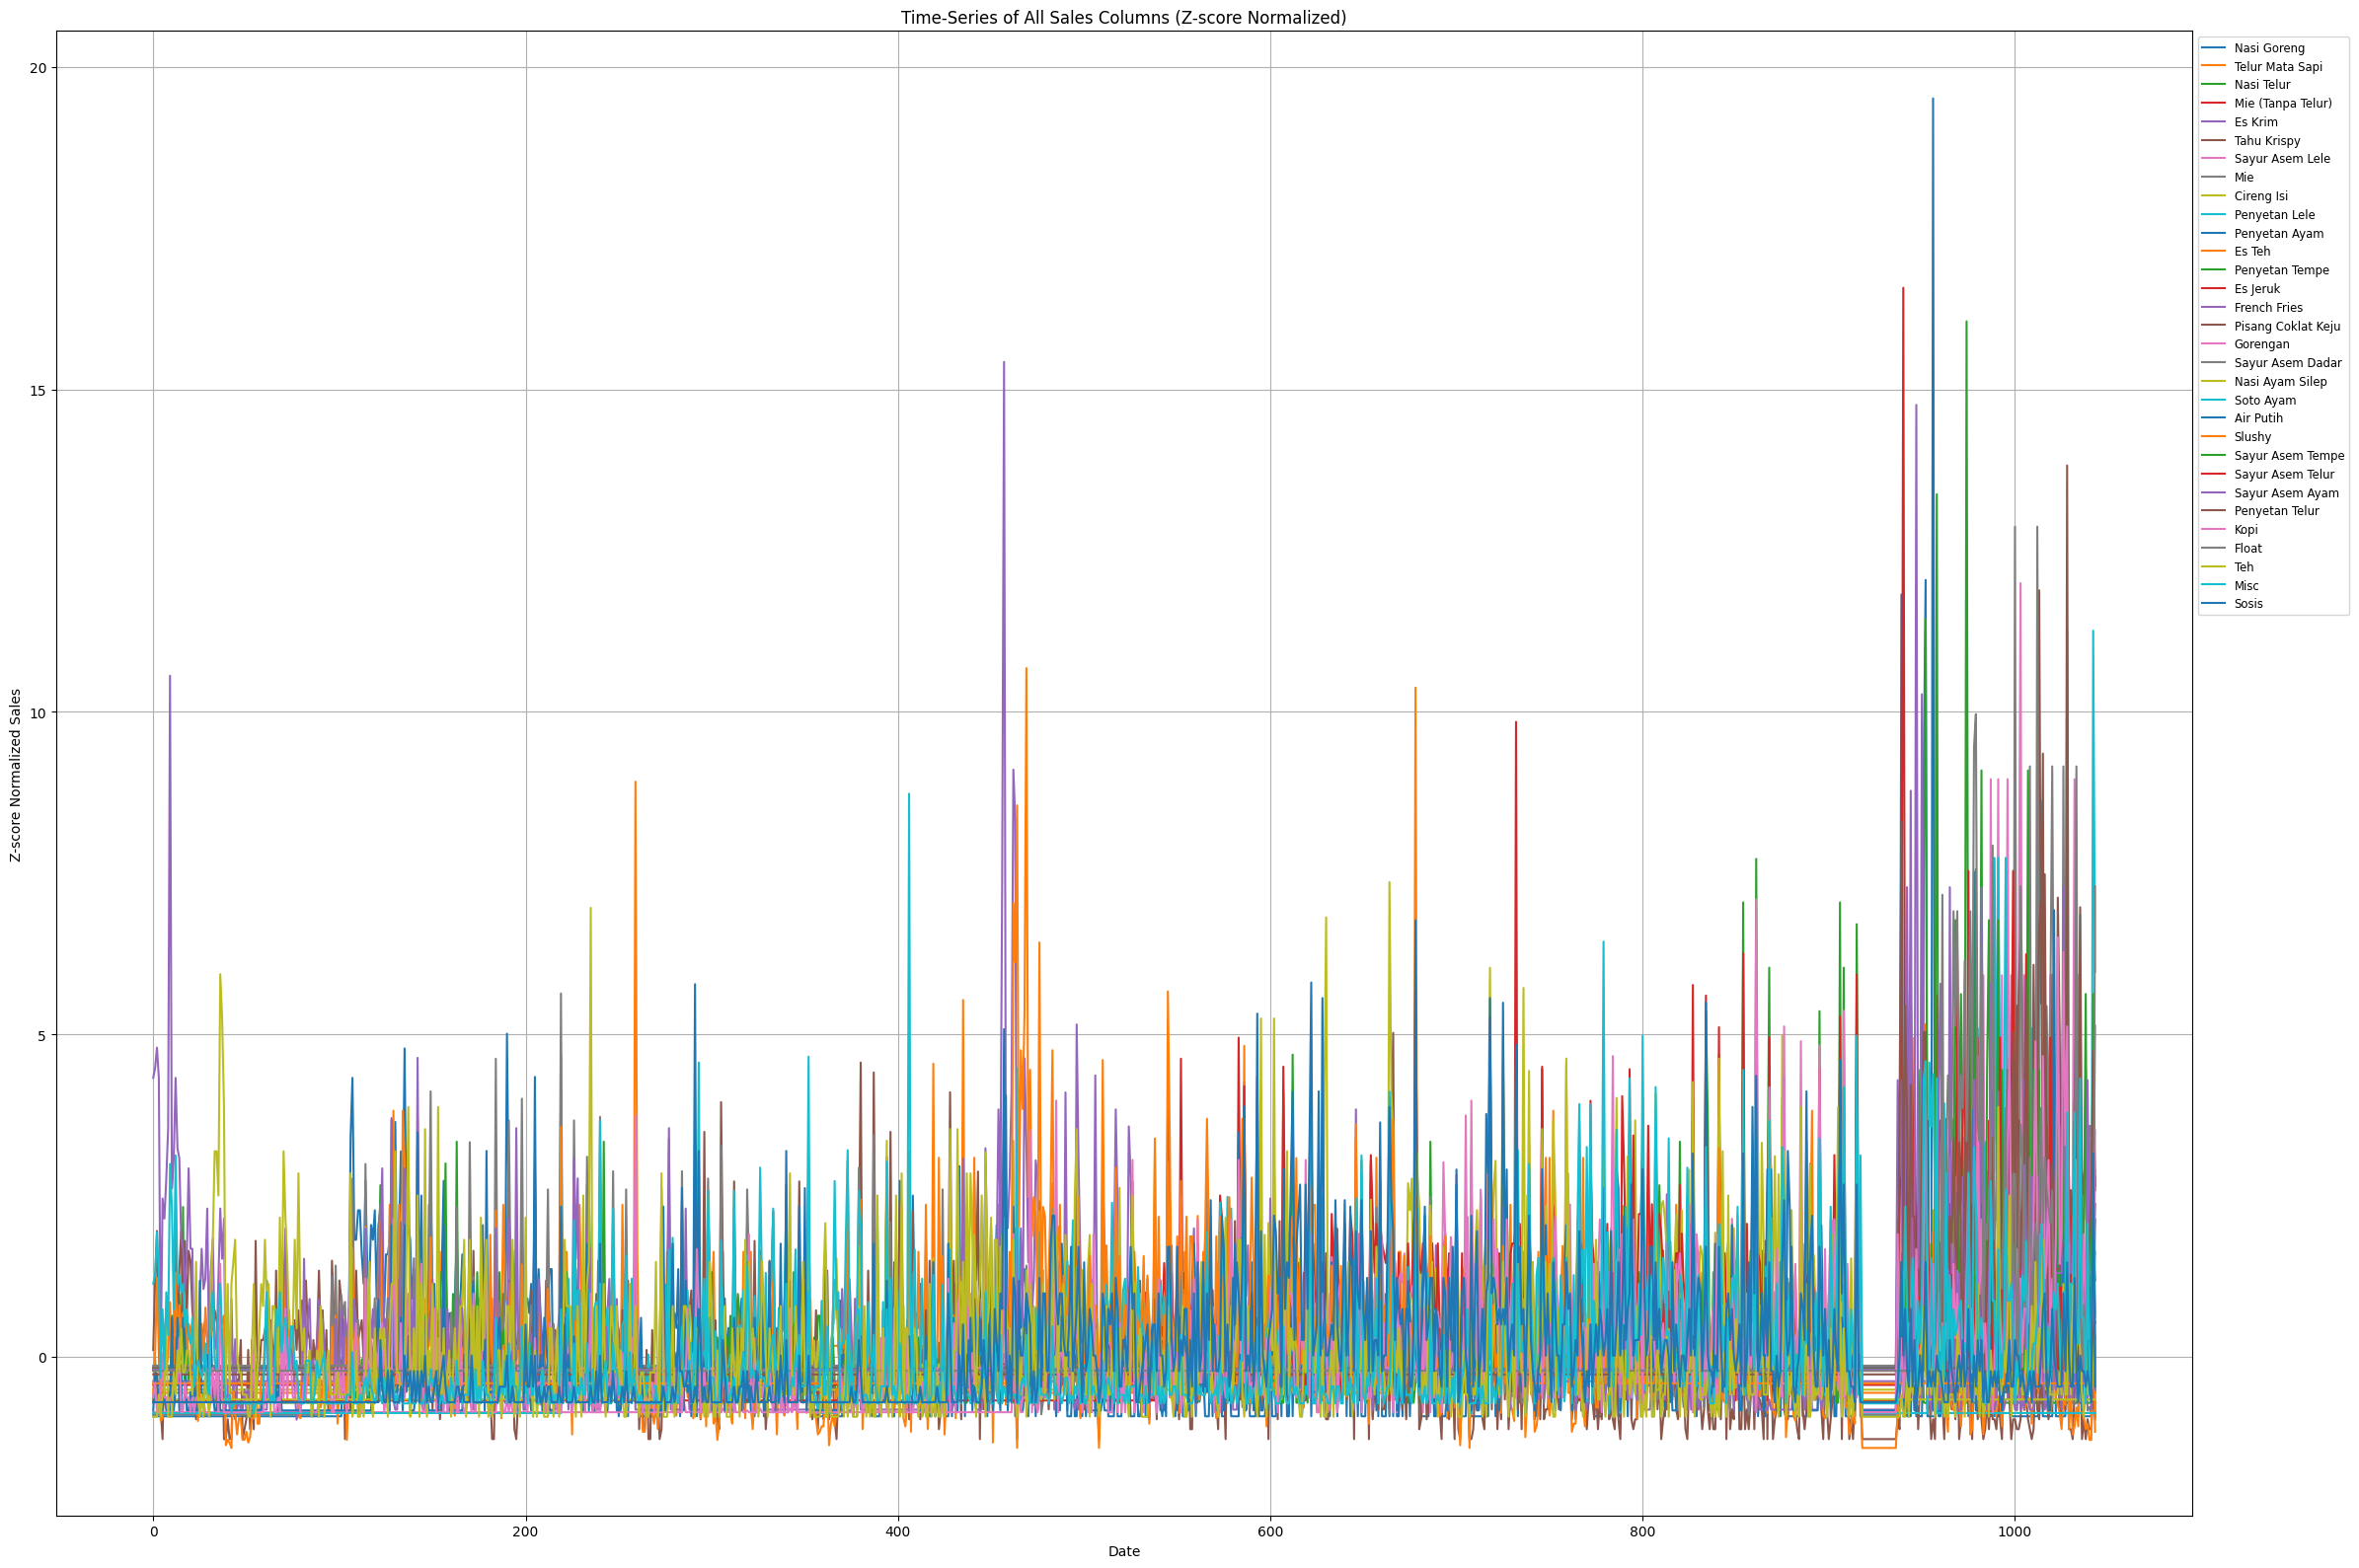

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns

# Apply Z-score normalization
df_scaled = df[numeric_cols].apply(zscore)

# Retain the original index (date)
df_scaled.index = df.index

# Plot each scaled numeric column as a separate time-series line
plt.figure(figsize=(24, 16))
for col in numeric_cols:
    plt.plot(df_scaled.index, df_scaled[col], label=col)

# Customize the plot
plt.title("Time-Series of All Sales Columns (Z-score Normalized)")
plt.xlabel("Date")
plt.ylabel("Z-score Normalized Sales")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


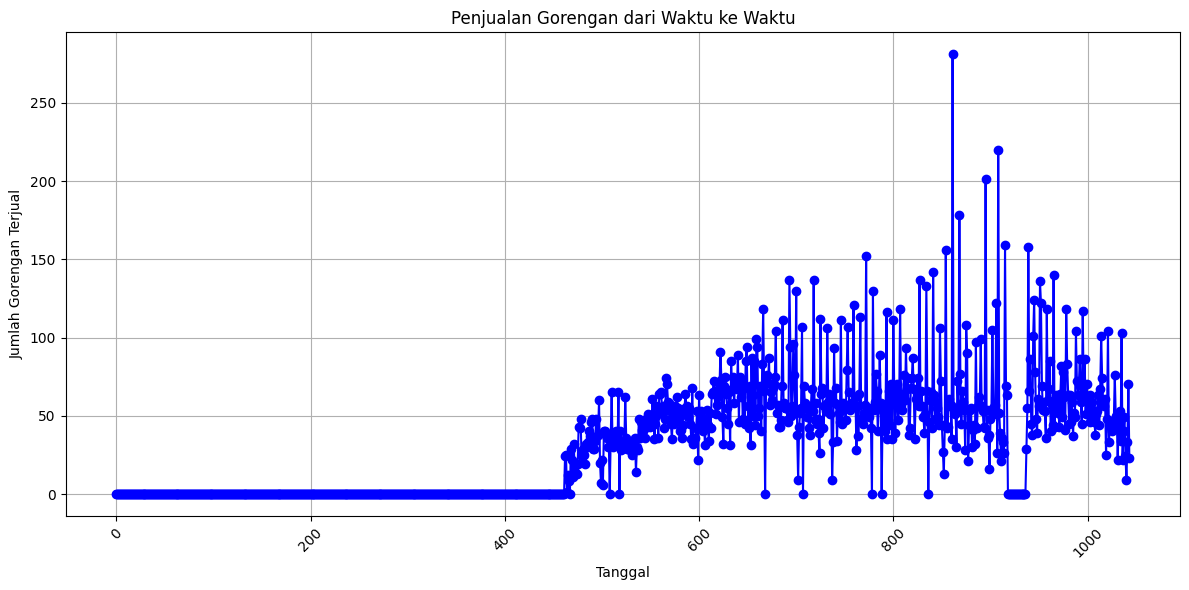

In [14]:
df = pd.read_excel('/content/dataframe (gorengan edited).xlsx')
df.to_csv('df.csv', index=False)
# # Convert 'date' column to datetime
# df['|__date'] = pd.to_datetime(df['|__date'], errors='coerce')
# df = df[df['|__date'] < '2023-01-01', '|__Gorengan'] = np.nan

# Example: Plotting 'Es Teh' sales over time
plt.figure(figsize=(12, 6))
plt.plot(df['Gorengan'], marker='o', linestyle='-', color='blue')

# Customize the plot
plt.title("Penjualan Gorengan dari Waktu ke Waktu")
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Gorengan Terjual")
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


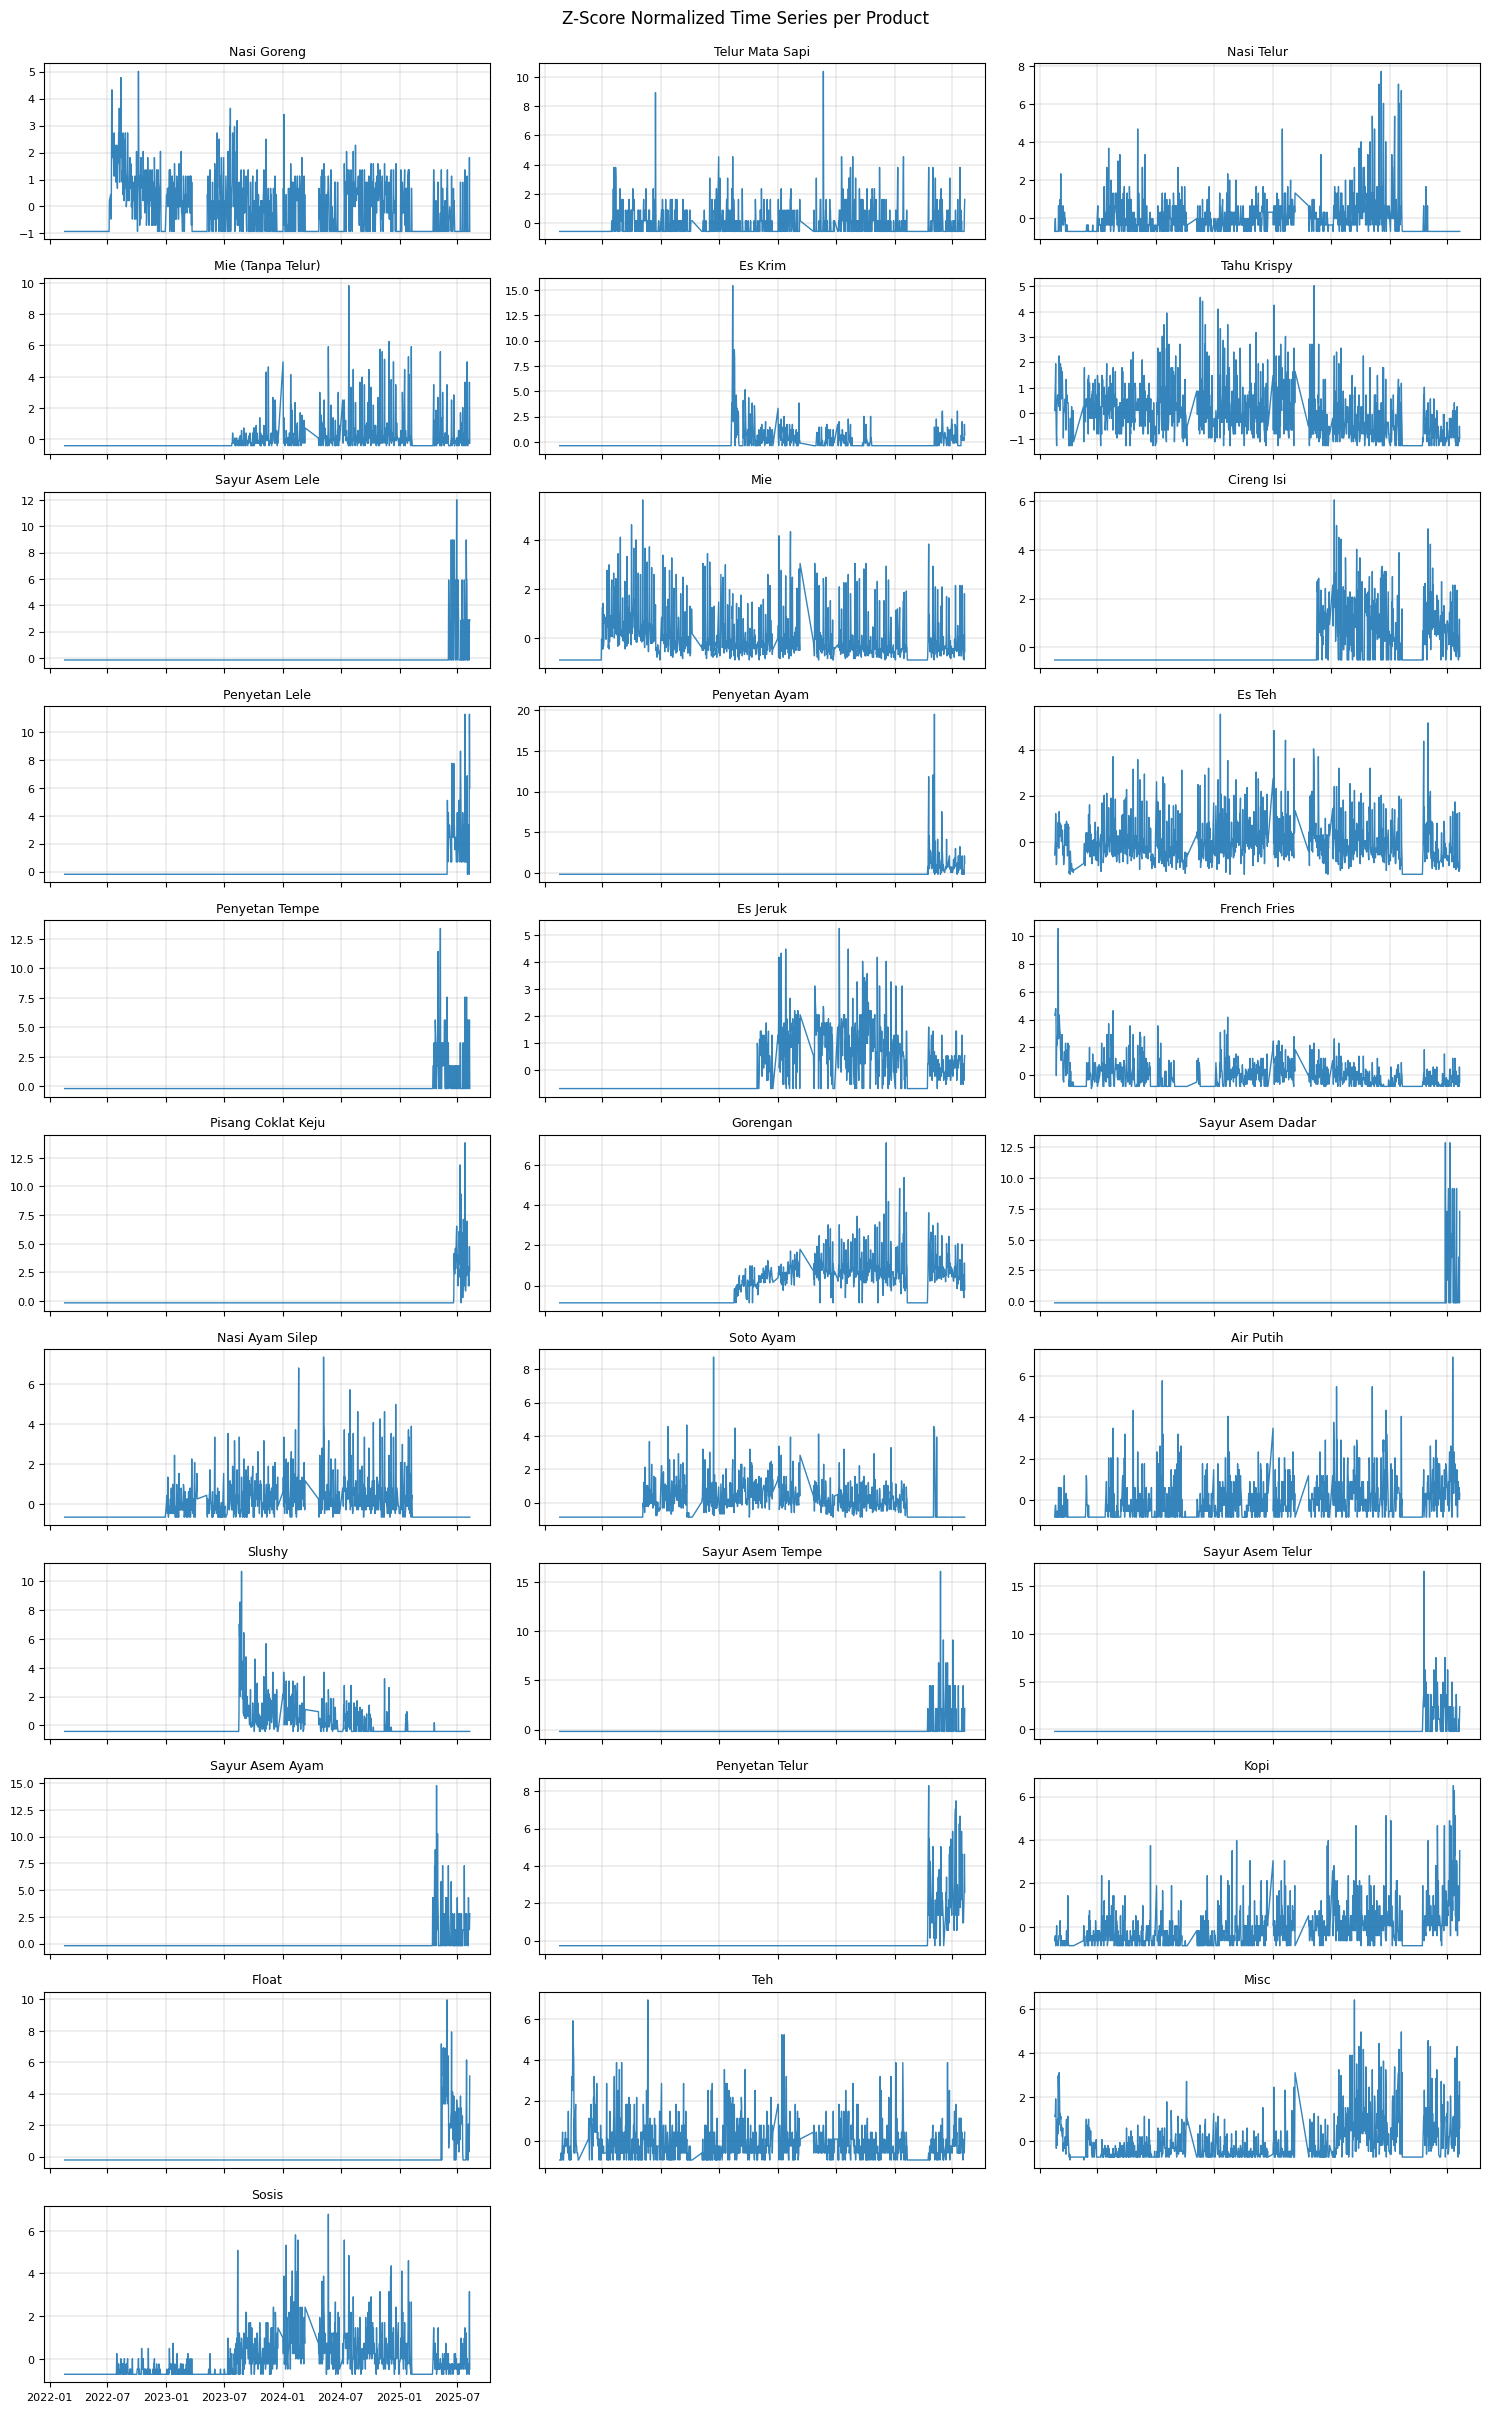

In [15]:
# pip install matplotlib pandas

# 1) Load
df = pd.read_csv("df.csv")

# 2) If there’s a date column, parse & move it to index (adjust the name if needed)
for cand in ["date","Date","tanggal","id"]:
    if cand in df.columns:
        df[cand] = pd.to_datetime(df[cand], errors="coerce")
        df = df.set_index(cand).sort_index()
        break
else:
    # no date column → synthesize a daily index
    df.index = pd.date_range(start="2022-02-21", periods=len(df), freq="D")

# 3) Keep only numeric product columns (coerce anything numeric-looking)
df = df.apply(pd.to_numeric, errors="coerce")
df = df.loc[:, df.notna().any()]          # drop all-NaN columns

# 4) Z-score per product (protect against std==0)
z = df.apply(lambda s: (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else 1), axis=0)

# 5) Grid of mini-plots
cols = list(z.columns)
n = len(cols)
cols_per_row = 3
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows*2.2), sharex=True)
axes = np.array(axes).ravel()

for i, col in enumerate(cols):
    ax = axes[i]
    ax.plot(z.index, z[col], linewidth=1, alpha=0.9)
    ax.set_title(col, fontsize=9)
    ax.grid(True, linewidth=0.3)
    ax.tick_params(labelsize=8)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Z-Score Normalized Time Series per Product", fontsize=12, y=0.995)
fig.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np

# -----------------------------
# 1) Load your wide daily data
# -----------------------------
# Assumes df.csv has rows = dates, columns = items
df = pd.read_csv("df.csv")

# If first column looks like dates, parse & set as index
first_col = df.columns[0]
if "date" in first_col.lower() or "tanggal" in first_col.lower():
    df[first_col] = pd.to_datetime(df[first_col], errors="coerce")
    df = df.set_index(first_col)

# Force numeric (non-numeric -> NaN)
df = df.apply(pd.to_numeric, errors="coerce")

# ----------------------------------------------------------
# 2) Trim helper: find active window and mask outside as NaN
# ----------------------------------------------------------
def trim_to_active(series: pd.Series,
                   treat_zeros_as_missing: bool = True,
                   min_active_points: int = 2) -> pd.Series:
    """
    Keep values only between first and last 'active' day.
    'Active' day is defined by non-missing and (optionally) >0.
    Outside that window -> NaN. Inside window -> keep original values.
    """
    s = series.copy()

    # For bounds, treat zeros as missing if requested
    s_for_bounds = s.copy()
    if treat_zeros_as_missing:
        s_for_bounds = s_for_bounds.replace(0, np.nan)

    # First and last valid (active) indices
    start = s_for_bounds.first_valid_index()
    end   = s_for_bounds.last_valid_index()

    # If no active window, return all-NaN
    if start is None or end is None:
        return pd.Series(np.nan, index=s.index, dtype=float)

    # Optionally require a minimum count of active points
    active_segment = s.loc[start:end]
    active_points = active_segment.dropna().shape[0]
    if treat_zeros_as_missing:
        active_points = active_segment.replace(0, np.nan).dropna().shape[0]

    if active_points < min_active_points:
        # not enough data to consider "active" -> all-NaN
        return pd.Series(np.nan, index=s.index, dtype=float)

    # Mask outside [start, end] as NaN, keep original values inside
    out = pd.Series(np.nan, index=s.index, dtype=float)
    out.loc[start:end] = s.loc[start:end].astype(float)
    return out

# ----------------------------------------------------------
# 3) Apply to all products and build a summary
# ----------------------------------------------------------
treat_zeros_as_missing = True   # set False if zeros should count as active days
min_active_points = 2           # increase if you want to ignore ultra-short lives

trimmed_cols = {}
summary_rows = []

for col in df.columns:
    trimmed = trim_to_active(df[col],
                             treat_zeros_as_missing=treat_zeros_as_missing,
                             min_active_points=min_active_points)
    trimmed_cols[col] = trimmed

    # Build summary
    non_nan = trimmed.dropna()
    if non_nan.empty:
        summary_rows.append({
            "item": col,
            "first_active": pd.NaT,
            "last_active": pd.NaT,
            "active_days": 0
        })
    else:
        summary_rows.append({
            "item": col,
            "first_active": non_nan.index[0],
            "last_active": non_nan.index[-1],
            "active_days": len(non_nan)
        })

trimmed_df = pd.DataFrame(trimmed_cols, index=df.index)

summary_df = pd.DataFrame(summary_rows).set_index("item").sort_values("first_active")

print("Trim complete.")
print("Rows (calendar days):", trimmed_df.shape[0], "| Items:", trimmed_df.shape[1])
print("\nActive-life summary (head):")
print(summary_df.head())

# ----------------------------------------
# 4) Save outputs for later use
# ----------------------------------------
trimmed_df.to_csv("trimmed_df.csv")
summary_df.to_csv("active_summary.csv")
print("\nSaved: trimmed_df.csv and active_summary.csv")

Trim complete.
Rows (calendar days): 1044 | Items: 34

Active-life summary (head):
             first_active last_active  active_days
item                                              
Kopi                    0        1043         1044
Tahu Krispy             0        1043         1044
Misc                    0        1043         1044
French Fries            0        1043         1044
Es Teh                  0        1043         1044

Saved: trimmed_df.csv and active_summary.csv


In [17]:
# --- Load your trimmed dataset ---
df = pd.read_csv("trimmed_df.csv", index_col=0, parse_dates=True)

# --- Apply 7-day rolling mean smoothing ---
df_smooth = df.rolling(window=30, min_periods=1).mean()

# --- Save to CSV if you want ---
df_smooth.to_csv("trimmed_df_smoothed_30day.csv")

df_smooth

/tmp/ipython-input-3083202907.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("trimmed_df.csv", index_col=0, parse_dates=True)


id  date  Nasi Goreng  Telur Mata Sapi  Nasi Telur  Mie (Tanpa Telur)  \
0    NaN   NaN          NaN              NaN         NaN                NaN   
1    NaN   NaN          NaN              NaN    2.000000                NaN   
2    NaN   NaN          NaN              NaN    1.000000                NaN   
3    NaN   NaN          NaN              NaN    0.666667                NaN   
4    NaN   NaN          NaN              NaN    0.500000                NaN   
...   ..   ...          ...              ...         ...                ...   
1039 NaN   NaN     1.166667         0.600000         NaN           4.833333   
1040 NaN   NaN     1.166667         0.600000         NaN           4.733333   
1041 NaN   NaN     1.166667         0.566667         NaN           4.633333   
1042 NaN   NaN     1.566667         0.633333         NaN           5.333333   
1043 NaN   NaN     1.620690         0.733333         NaN           5.333333   

      month   Es Krim  Tahu Krispy  Sayur Asem Lele  ...  Slushy  \
0       NaN       NaN     9.000000              NaN  ...     NaN   
1       NaN       NaN    12.500000              NaN  ...     NaN   
2       NaN       NaN    15.333333              NaN  ...     NaN   
3       NaN       NaN    13.750000              NaN  ...     NaN   
4       NaN       NaN    11.600000              NaN  ...     NaN   
...     ...       ...          ...              ...  ...     ...   
1039    NaN  2.633333     4.233333         0.600000  ...     NaN   
1040    NaN  2.566667     4.233333         0.633333  ...     NaN   
1041    NaN  2.533333     4.033333         0.633333  ...     NaN   
1042    NaN  2.766667     4.100000         0.666667  ...     NaN   
1043    NaN  2.633333     4.100000         0.700000  ...     NaN   

      Sayur Asem Tempe  Sayur Asem Telur  Sayur Asem Ayam  Penyetan Telur  \
0                  NaN               NaN              NaN             NaN   
1                  NaN               NaN              NaN             NaN   
2                  NaN               NaN              NaN             NaN   
3                  NaN               NaN              NaN             NaN   
4                  NaN               NaN              NaN             NaN   
...                ...               ...              ...             ...   
1039          0.533333          0.933333         0.966667        7.966667   
1040          0.466667          0.966667         1.000000        8.066667   
1041          0.433333          0.900000         1.000000        8.100000   
1042          0.400000          0.900000         0.966667        8.133333   
1043          0.366667          0.900000         1.033333        7.800000   

           Kopi     Float       Teh       Misc     Sosis  
0      1.000000       NaN       NaN  14.000000       NaN  
1      1.500000       NaN       NaN  14.500000       NaN  
2      1.000000       NaN       NaN  16.333333       NaN  
3      0.750000       NaN  1.000000  16.000000       NaN  
4      0.800000       NaN  0.500000  13.400000       NaN  
...         ...       ...       ...        ...       ...  
1039  12.366667  5.833333  2.666667  12.100000  2.733333  
1040  12.133333  5.666667  2.666667  11.900000  2.700000  
1041  11.466667  5.466667  2.466667  11.900000  2.666667  
1042  11.333333  5.533333  2.466667  12.433333  3.166667  
1043  11.566667  5.900000  2.466667  12.366667  3.166667  

[1044 rows x 34 columns]

/tmp/ipython-input-2555392839.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("trimmed_df.csv", index_col=0, parse_dates=True)


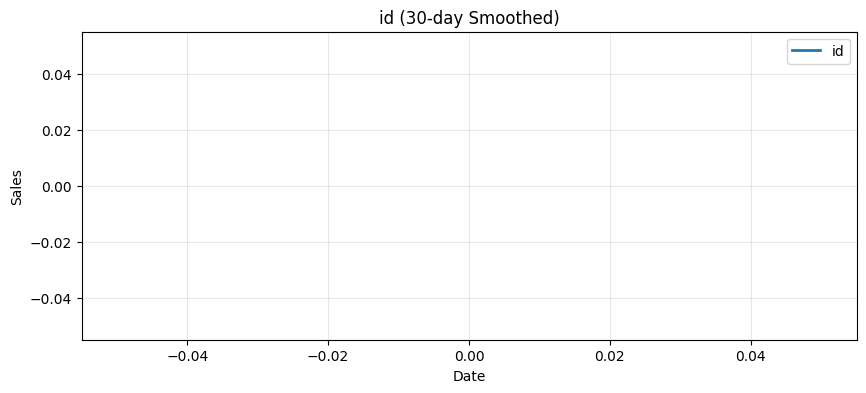

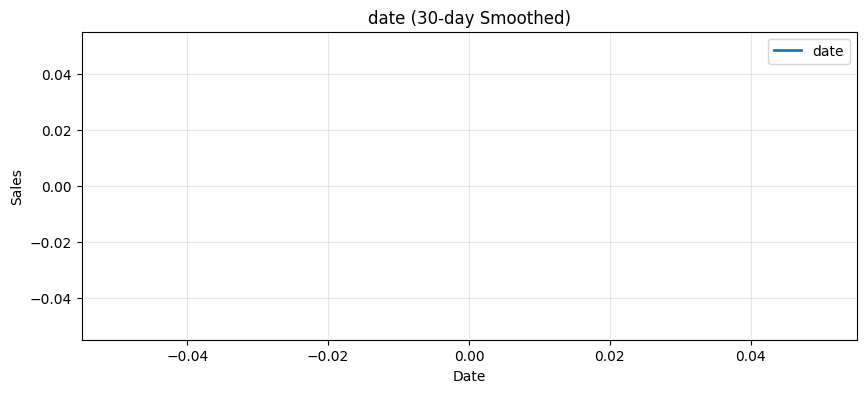

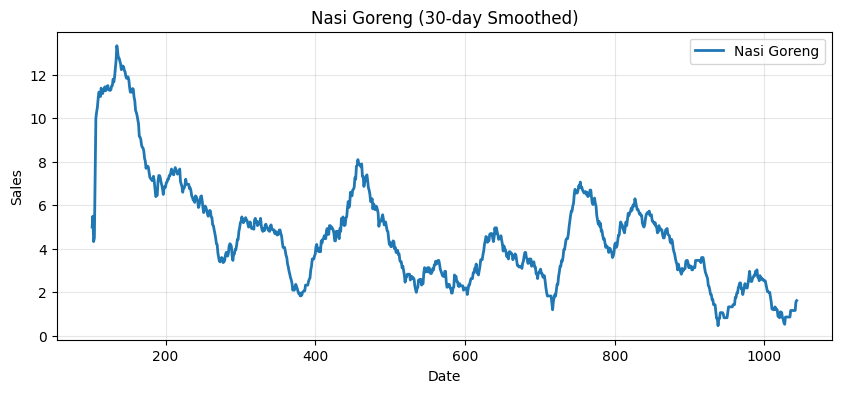

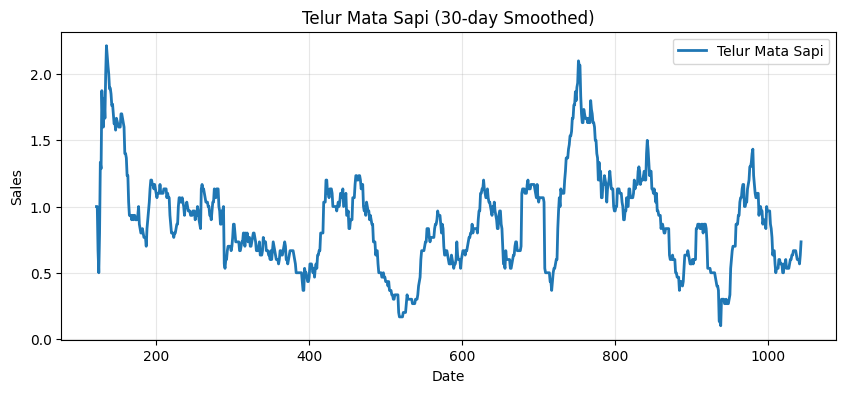

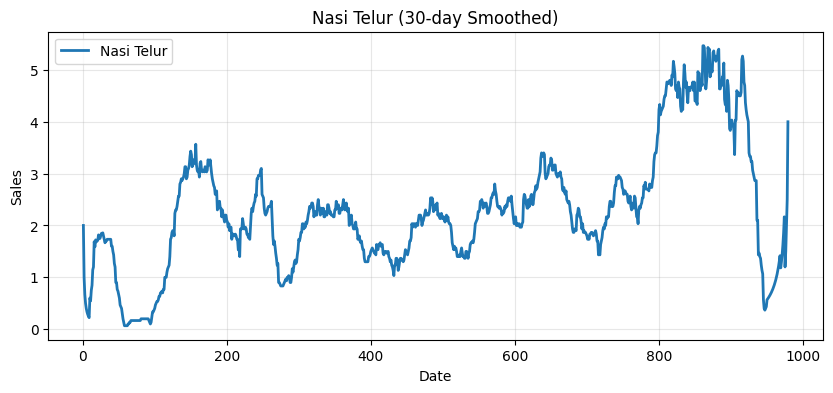

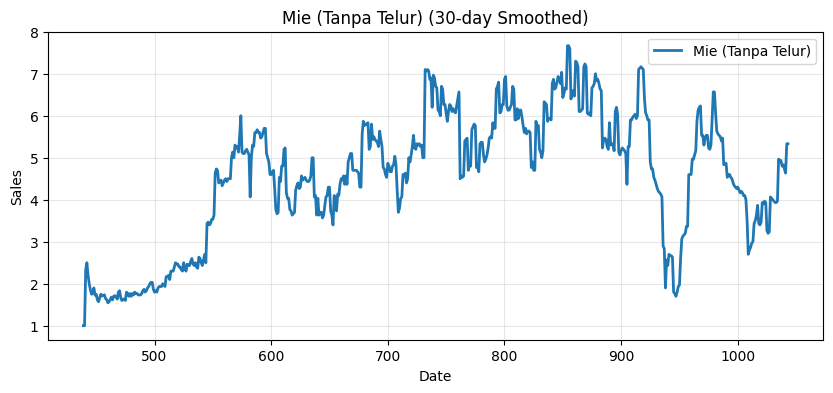

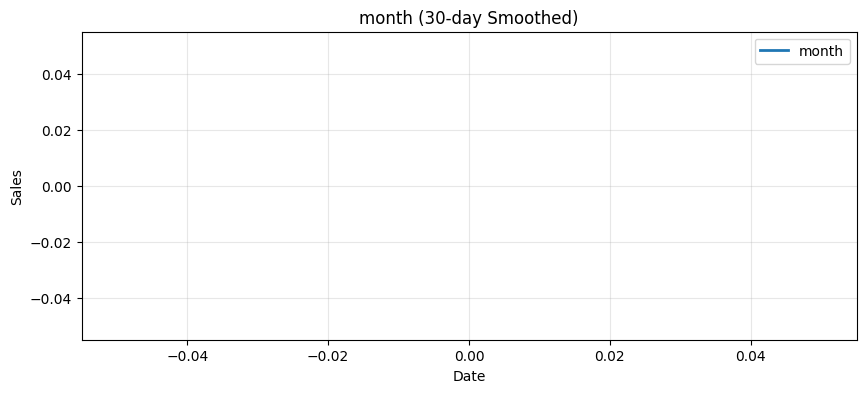

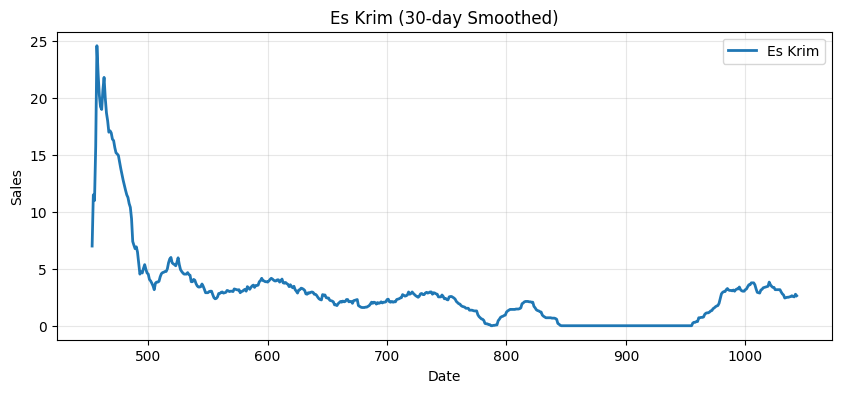

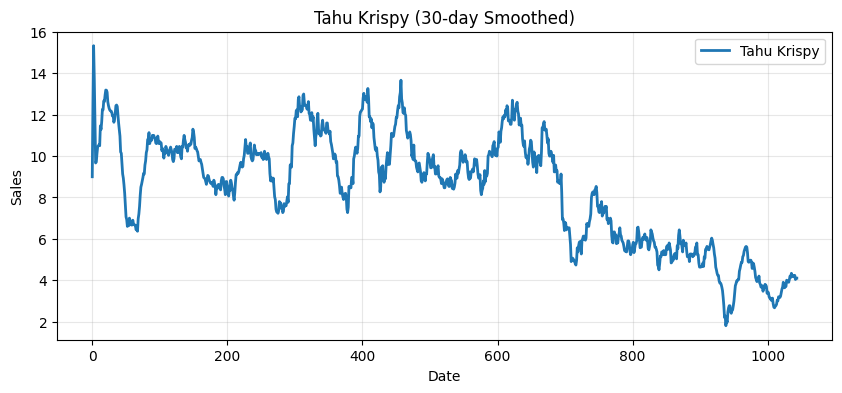

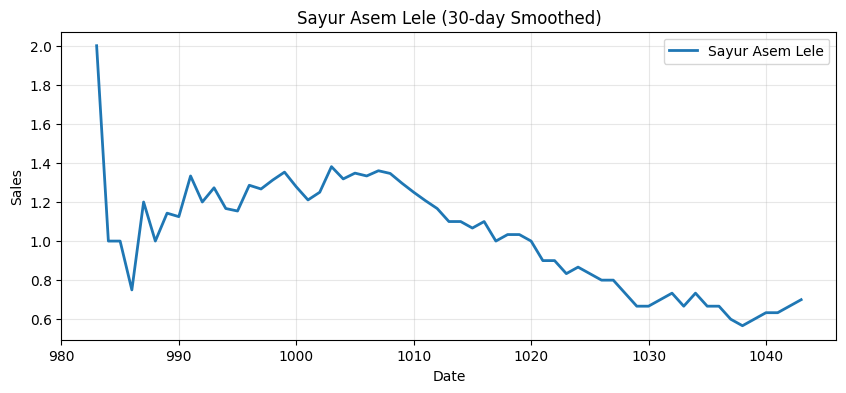

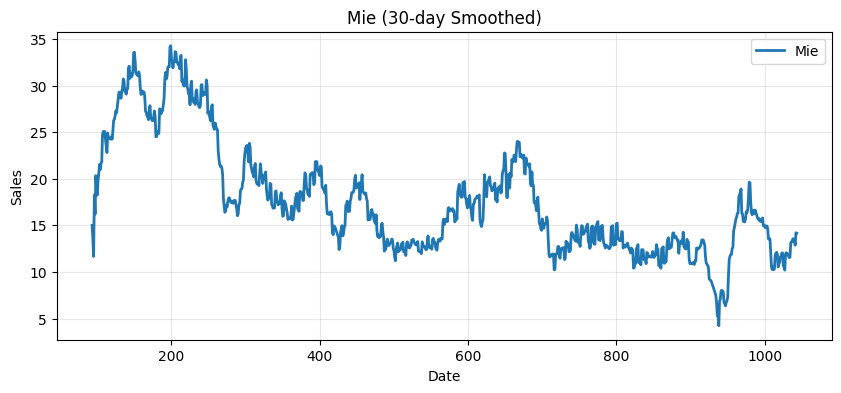

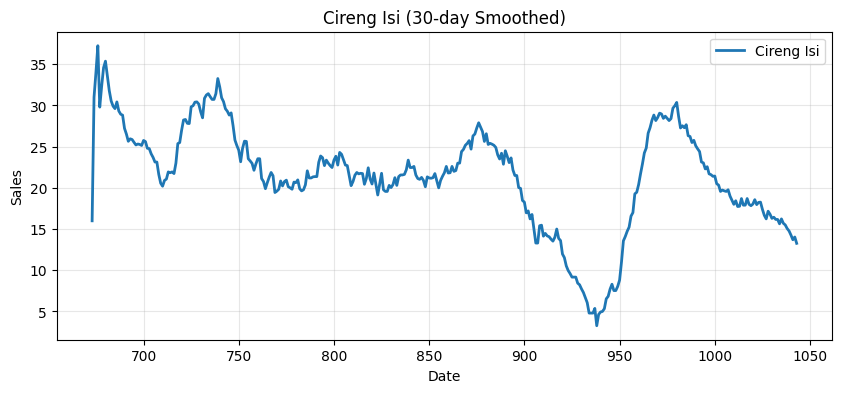

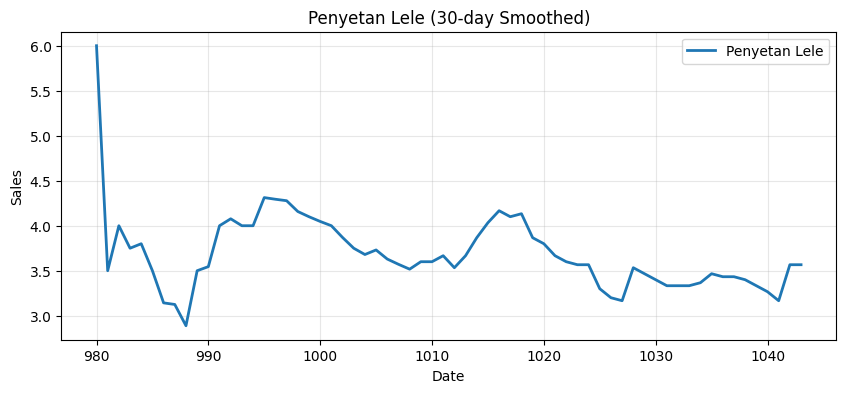

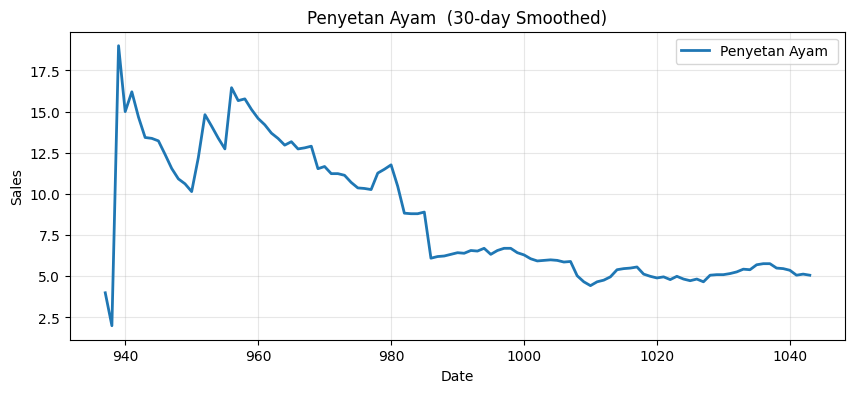

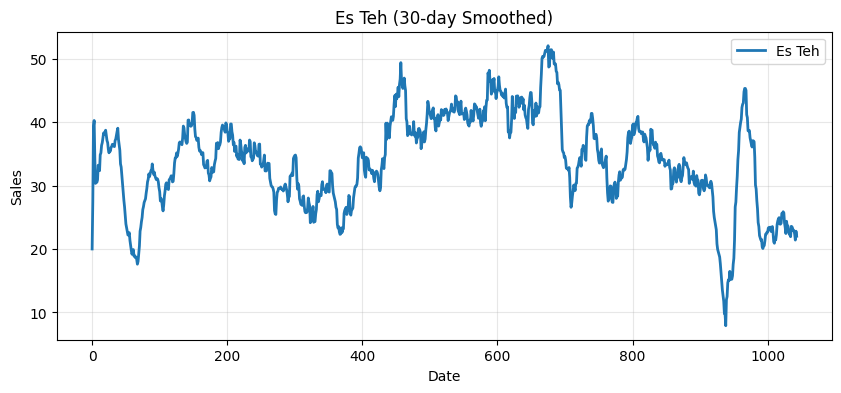

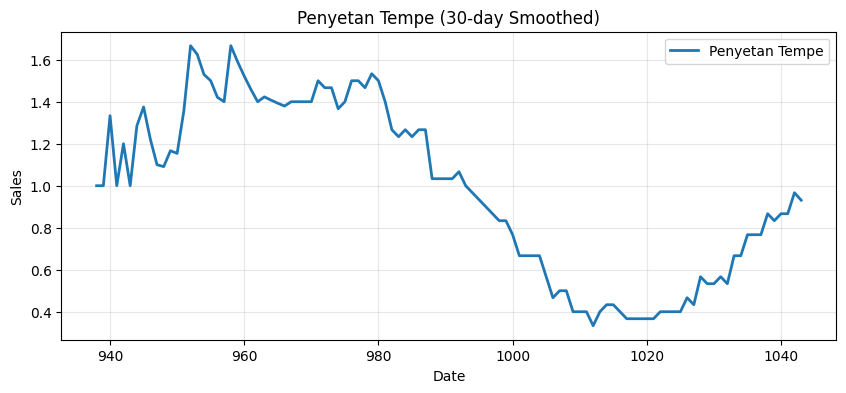

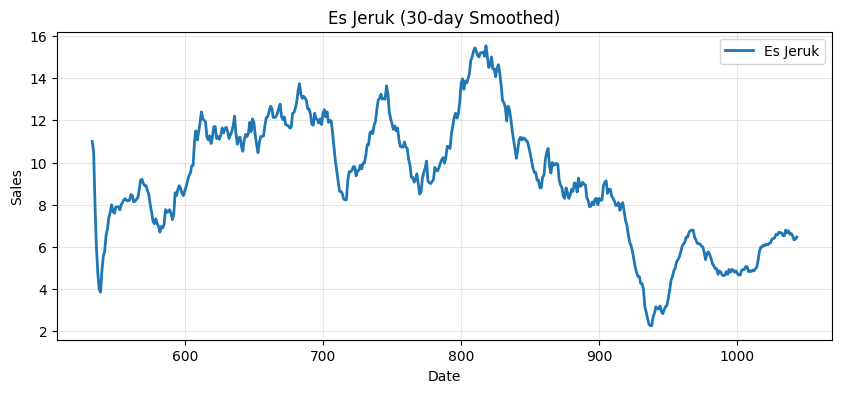

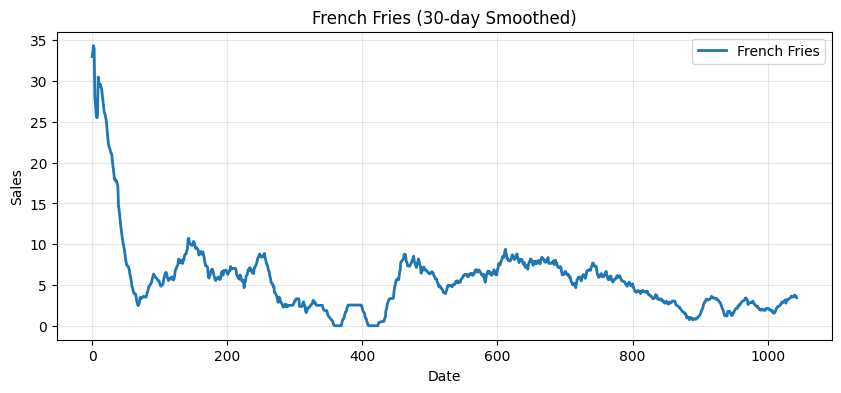

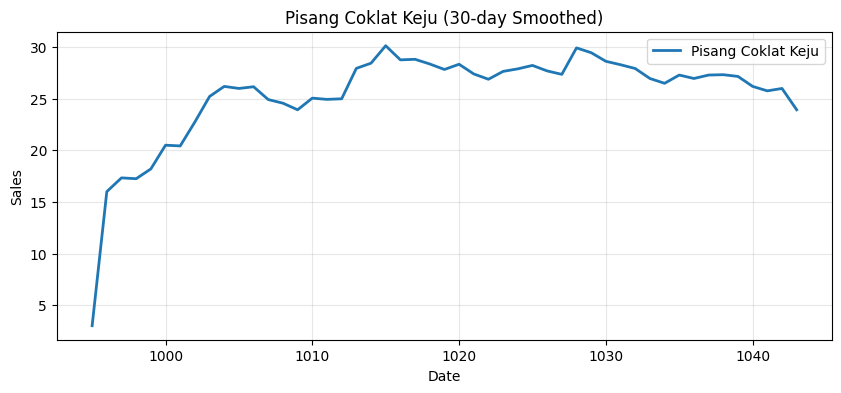

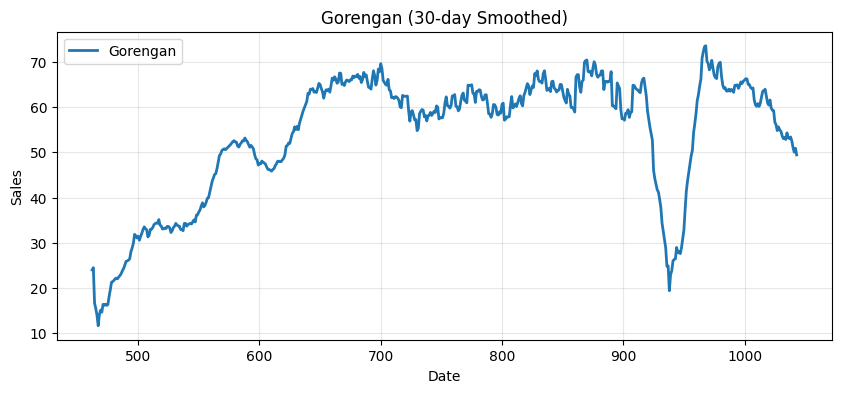

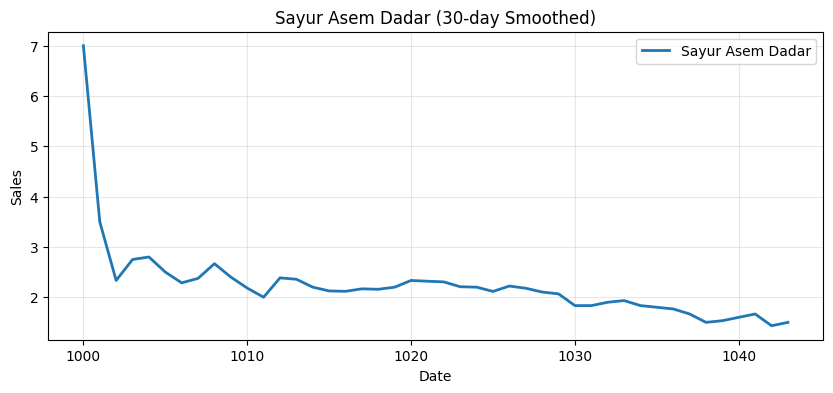

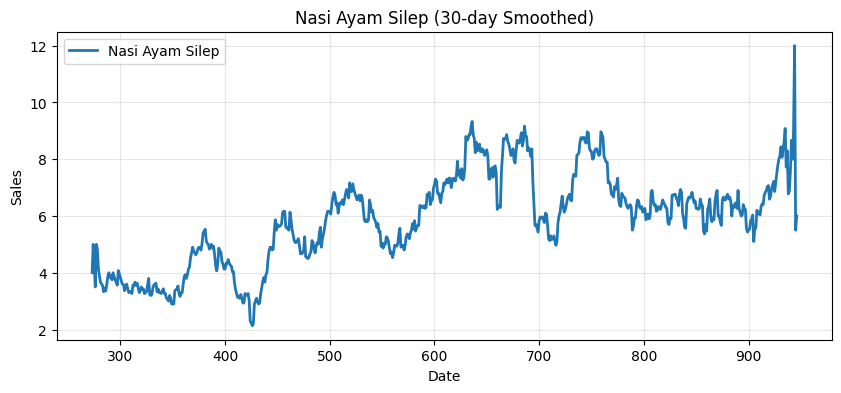

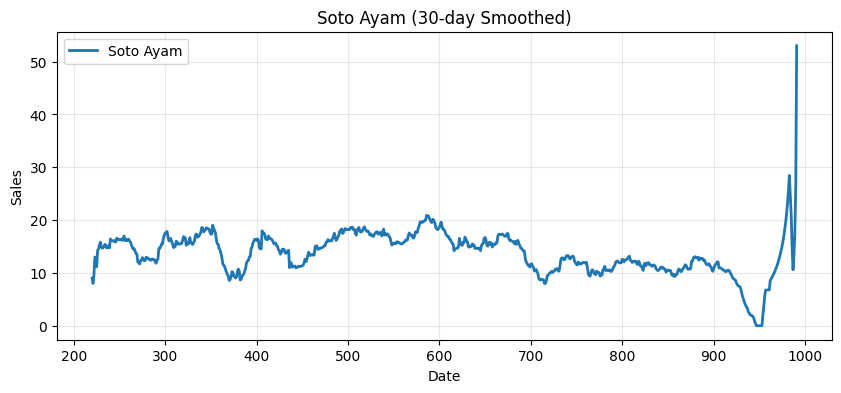

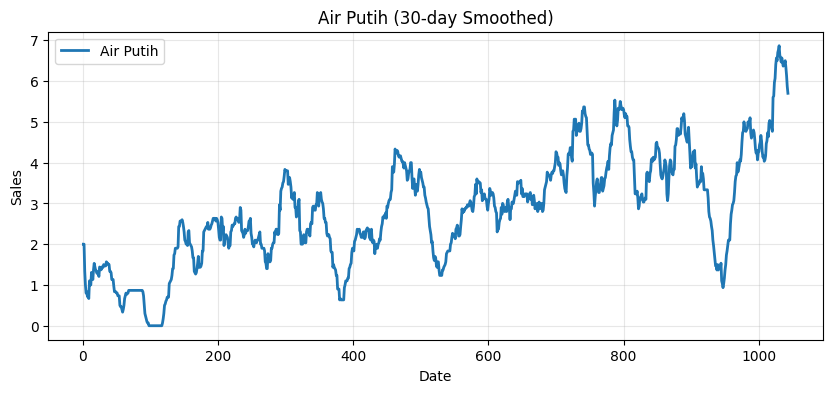

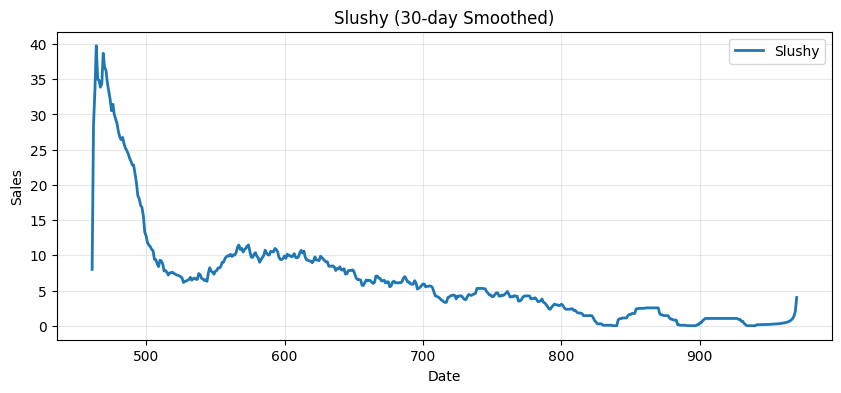

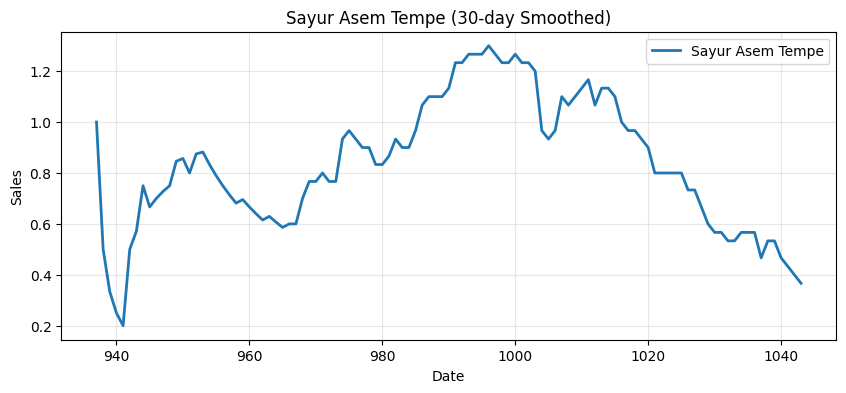

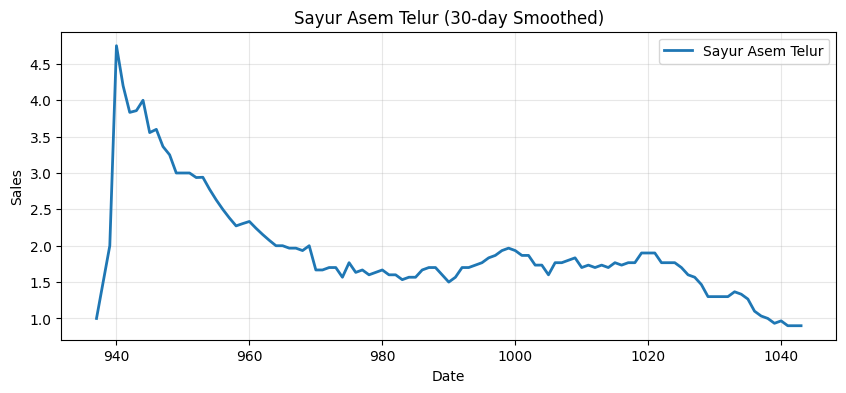

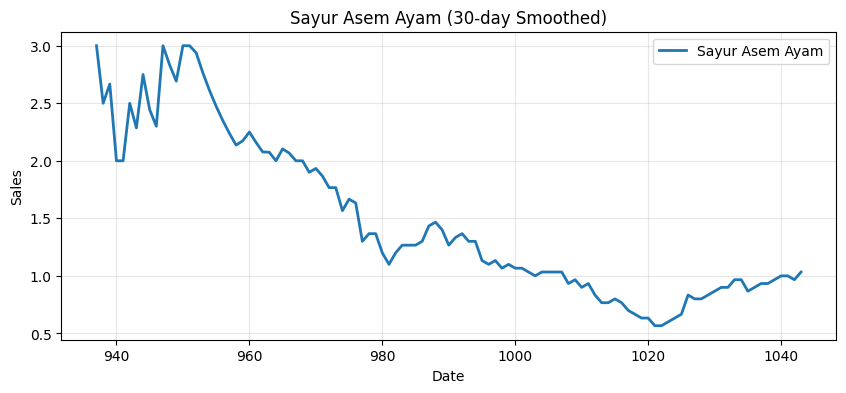

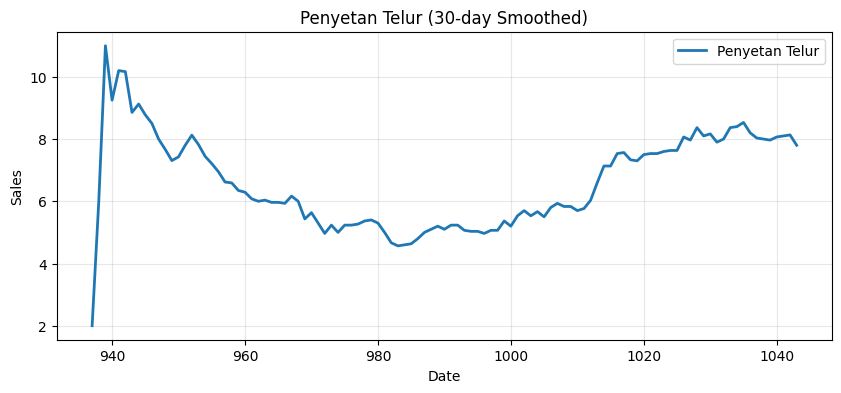

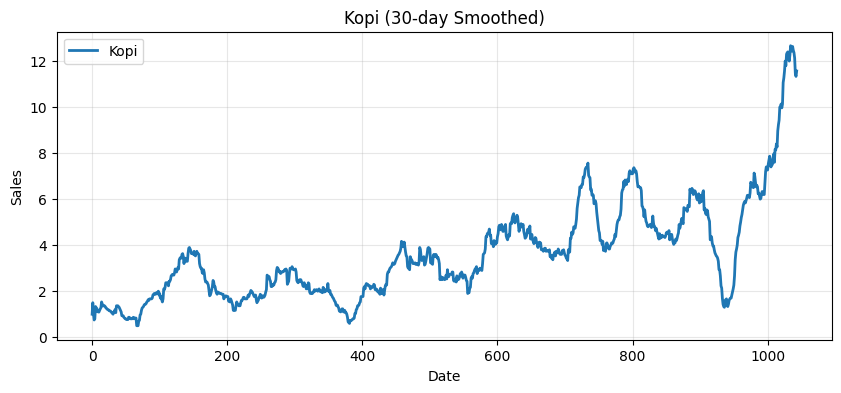

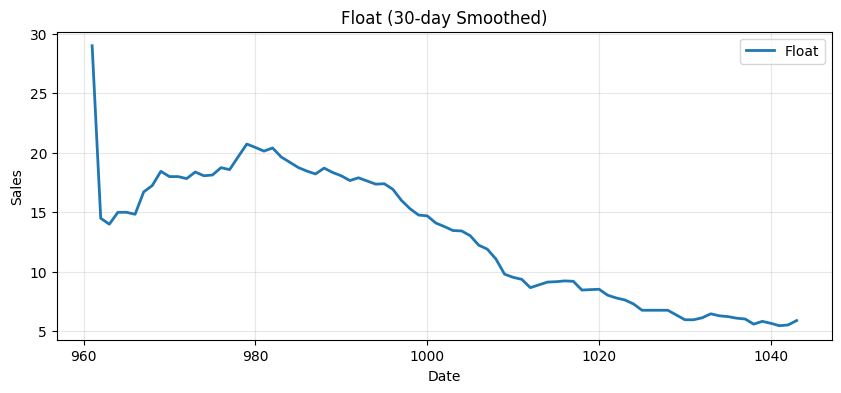

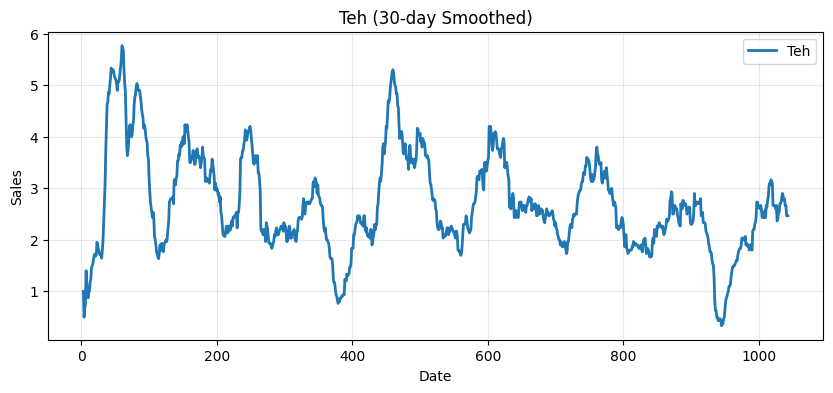

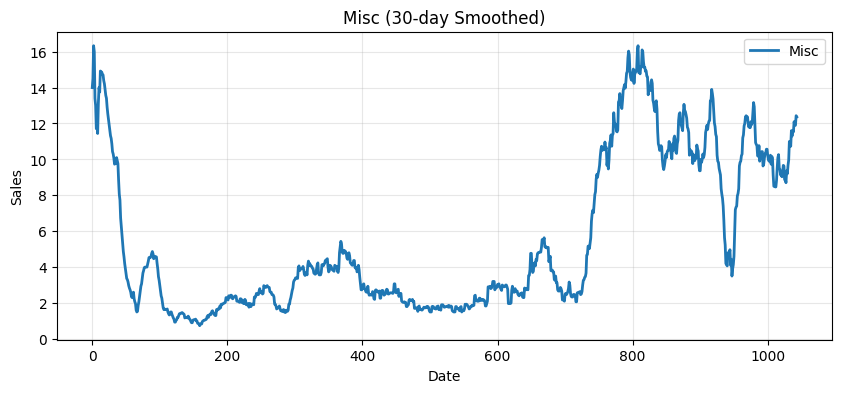

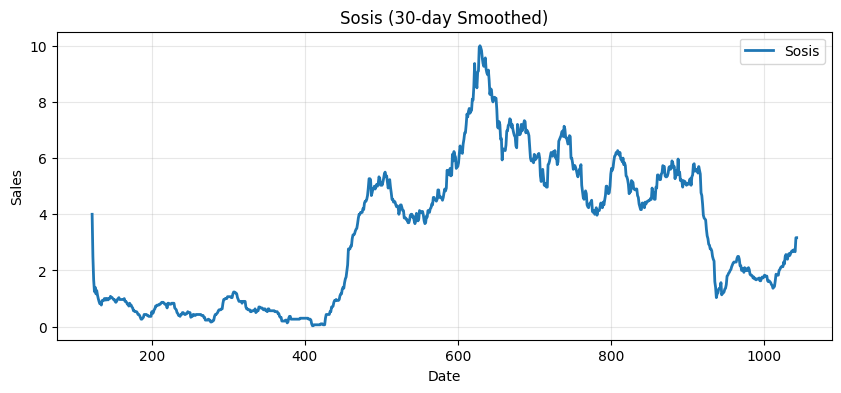

In [18]:
# --- Load dataset ---
df = pd.read_csv("trimmed_df.csv", index_col=0, parse_dates=True)

# --- Apply 7-day smoothing ---
df_smooth = df.rolling(window=30, min_periods=1).mean()

# --- Plot each item in its own subplot ---
for col in df_smooth.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df_smooth.index, df_smooth[col], label=col, linewidth=2)
    plt.title(f"{col} (30-day Smoothed)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [19]:
# --- 1) Load the smoothed (30-day) trimmed data ---
df = pd.read_csv("trimmed_df_smoothed_30day.csv", index_col=0, parse_dates=True)

# --- 2) Resample each item to fixed length (L=90), keeping only active values (already trimmed) ---
def resample_to_fixed_length(series: pd.Series, L: int = 90):
    """
    Assumes series is already trimmed to active span and smoothed.
    Returns a 1D numpy array of length L (or None if too short).
    """
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) < 2:
        return None  # need >=2 points to interpolate

    x_old = np.linspace(0, 1, len(s))
    f = interp1d(x_old, s.values, kind="linear")
    x_new = np.linspace(0, 1, L)
    y_new = f(x_new)
    return y_new

L = 90
resampled = {col: resample_to_fixed_length(df[col], L=L) for col in df.columns}
# drop items that couldn't be resampled
resampled = {k: v for k, v in resampled.items() if v is not None}

# --- 3) Build matrix with rows=timepoints and columns=items ---
resampled_df = pd.DataFrame(resampled)
resampled_df.index = [f"t{i+1}" for i in range(L)]

# Save for later steps (e.g., L2 normalization + clustering)
resampled_df.to_csv("resampled_90points_timeseries.csv")
print("Resampled shape:", resampled_df.shape)
display(resampled_df.head())

Resampled shape: (90, 31)


/tmp/ipython-input-945675124.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("trimmed_df_smoothed_30day.csv", index_col=0, parse_dates=True)


Nasi Goreng  Telur Mata Sapi  Nasi Telur  Mie (Tanpa Telur)    Es Krim  \
t1     5.000000         1.000000    2.000000           1.000000   7.000000   
t2    11.077630         1.765407    0.747702           1.772873  19.634029   
t3    11.471422         1.769444    1.783408           1.626003  17.741573   
t4    12.563670         1.604494    1.732210           1.592587  15.242108   
t5    12.317978         1.154682    1.202996           1.710688  12.541912   

    Tahu Krispy  Sayur Asem Lele        Mie  Cireng Isi  Penyetan Lele  ...  \
t1     9.000000         2.000000  15.000000   16.000000       6.000000  ...   
t2    11.191443         1.325843  21.177732   30.198502       4.230337  ...   
t3    12.543933         1.000000  24.728738   33.003246       3.707865  ...   
t4    12.438577         0.994382  27.262172   29.999136       3.969101  ...   
t5     8.641199         0.825843  30.560674   27.815965       3.792135  ...   

       Slushy  Sayur Asem Tempe  Sayur Asem Telur  Sayur Asem Ayam  \
t1   8.000000          1.000000          1.000000         3.000000   
t2  34.131354          0.468165          1.595506         2.531835   
t3  33.977528          0.301498          3.050562         2.411985   
t4  29.231224          0.221348          4.434831         2.000000   
t5  25.981803          0.429213          3.919850         2.382022   

    Penyetan Telur      Kopi      Float       Teh       Misc     Sosis  
t1        2.000000  1.000000  29.000000  1.000000  14.000000  4.000000  
t2        6.955056  1.212763  15.640449  1.394987  14.593561  0.823459  
t3       10.331461  1.204682  14.078652  1.765094  12.409476  0.968335  
t4        9.794382  1.113858  14.764045  4.635206   9.819101  0.868165  
t5       10.174532  0.874906  15.000000  5.141948   4.603745  0.979775  

[5 rows x 31 columns]

In [20]:
# --- Plot a single item by name ---
def plot_item(item_name: str):
    if item_name not in resampled_df.columns:
        raise ValueError(f"Item '{item_name}' not found.")
    y = resampled_df[item_name].values
    x = np.arange(len(y))
    plt.figure(figsize=(7,3))
    plt.plot(x, y, linewidth=2)
    plt.title(f"{item_name} — Resampled to {L} points")
    plt.xlabel("Relative life (0 → 100%)")
    plt.ylabel("Smoothed sales")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example:
# plot_item("Es Teh")
# plot_item("Gorengan")

# --- Plot all items as small multiples (grid) ---
def plot_all_small_multiples(cols_per_row=4, height_per_row=2.2):
    items = list(resampled_df.columns)
    n = len(items)
    rows = math.ceil(n / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row*4, rows*height_per_row), sharex=True)
    axes = axes.ravel()

    x = np.arange(L)
    for i, item in enumerate(items):
        ax = axes[i]
        ax.plot(x, resampled_df[item].values, linewidth=1.3)
        ax.set_title(item, fontsize=9)
        ax.grid(True, alpha=0.3)
        if i // cols_per_row == rows - 1:
            ax.set_xlabel("Relative life")
        ax.set_ylabel("Smoothed sales")

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Resampled Time Series (L={L})", y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()

# Example:
# plot_all_small_multiples(cols_per_row=4)

# --- (Optional) Save one PNG per item ---
def save_each_item(outdir="plots_resampled90"):
    Path(outdir).mkdir(parents=True, exist_ok=True)
    x = np.arange(L)
    for item in resampled_df.columns:
        plt.figure(figsize=(7,3))
        plt.plot(x, resampled_df[item].values, linewidth=2)
        plt.title(item)
        plt.xlabel("Relative life (0 → 100%)")
        plt.ylabel("Smoothed sales")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{outdir}/{item}.png", dpi=150)
        plt.close()

# Example:
# save_each_item()

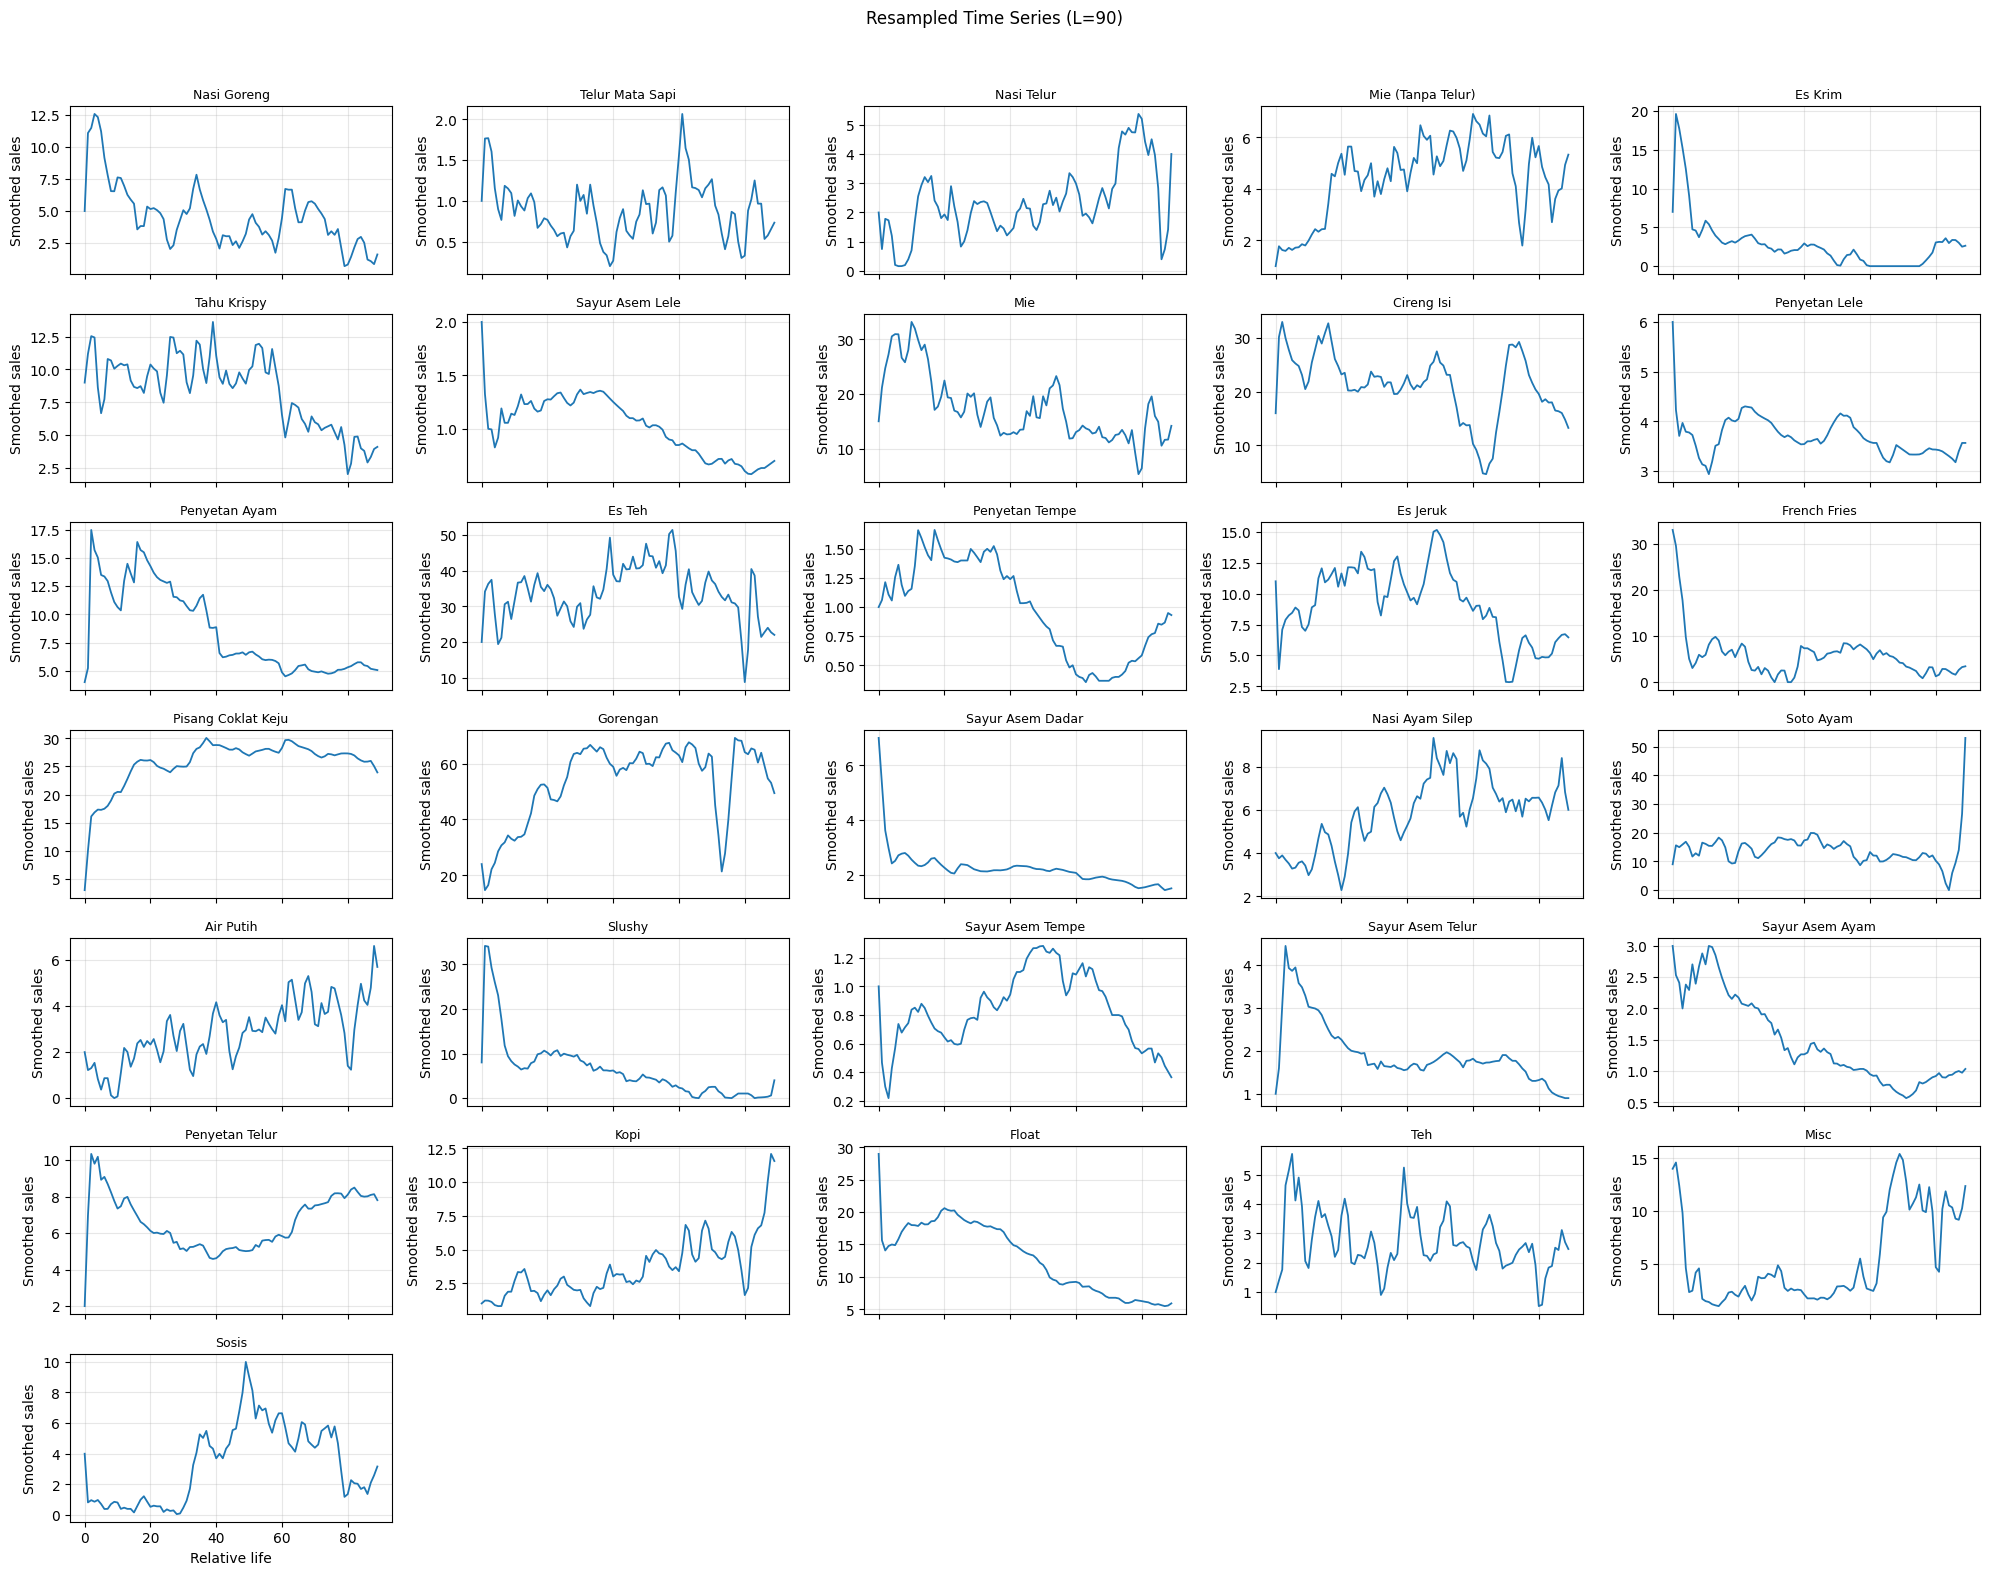

In [21]:
plot_all_small_multiples(cols_per_row=5)

In [22]:
# # --- Load the resampled dataset ---
# df = pd.read_csv("resampled_90points_timeseries.csv", index_col=0)

# # --- Row-wise (L2) normalization ---
# def l2_normalize(row):
#     norm = np.linalg.norm(row.values)
#     return row / norm if norm > 0 else row

# df_normalized = df.apply(l2_normalize, axis=1)

# # --- Save normalized result ---
# df_normalized.to_csv("resampled_90points_rowwise_normalized.csv")

# print("Row-wise normalization complete. Shape:", df_normalized.shape)

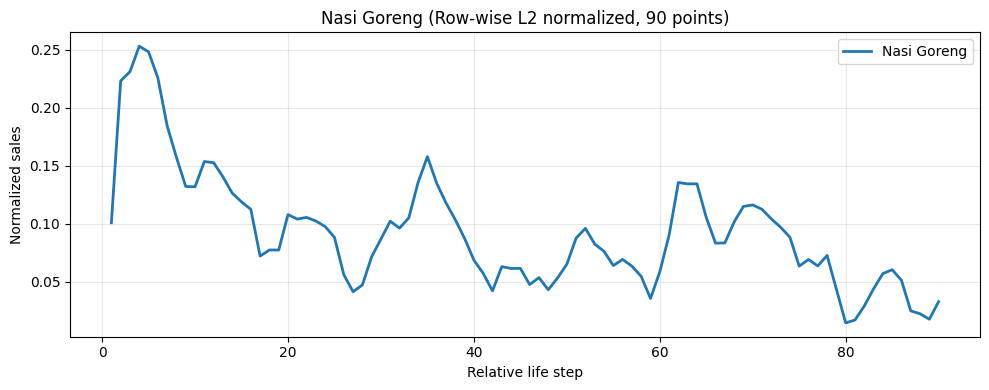

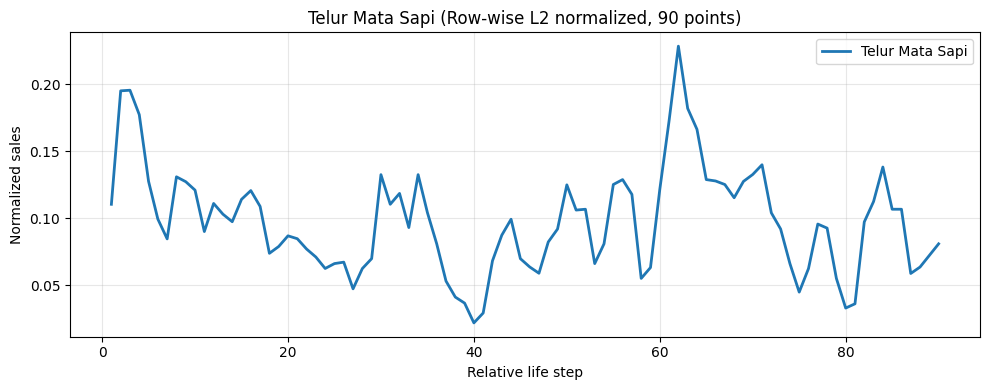

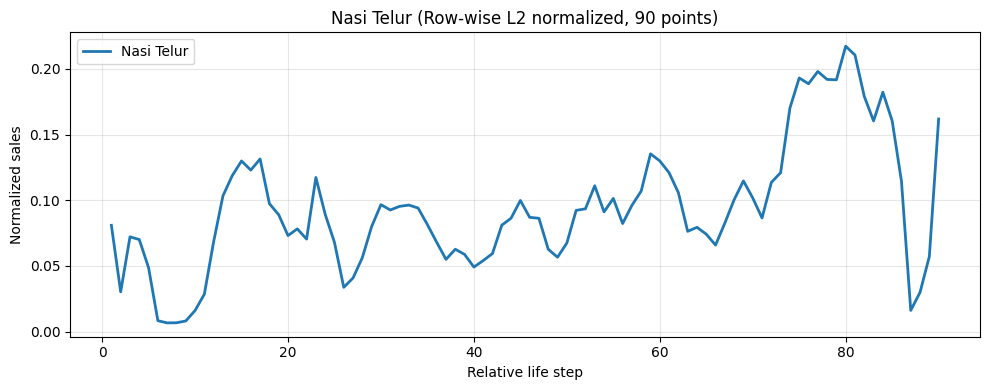

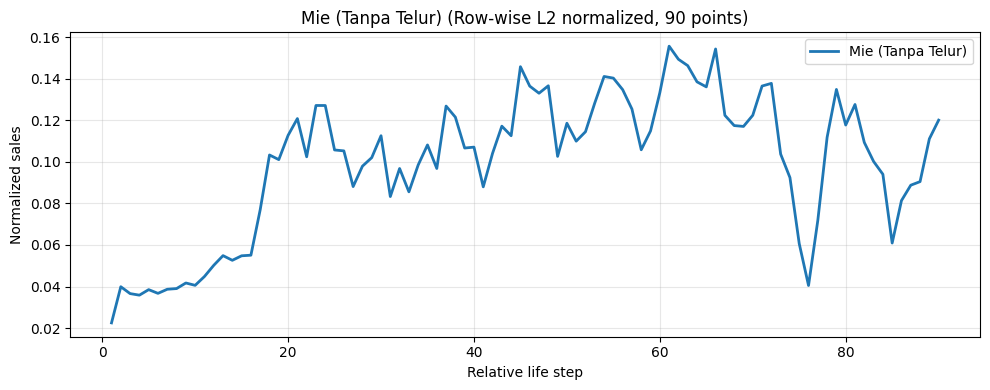

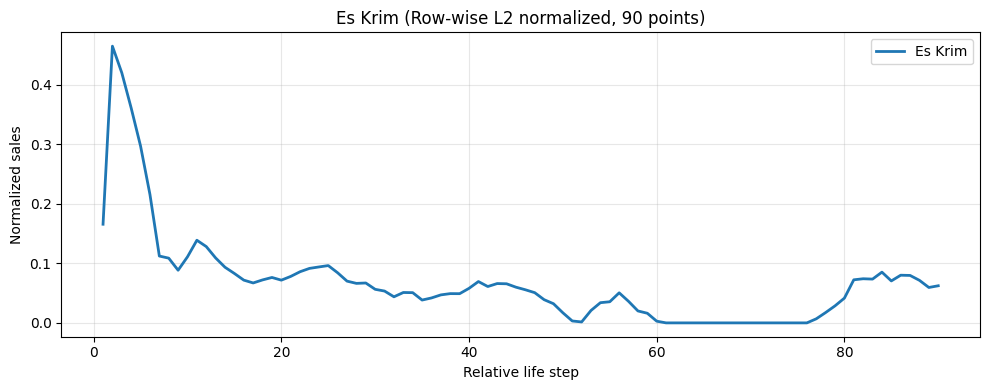

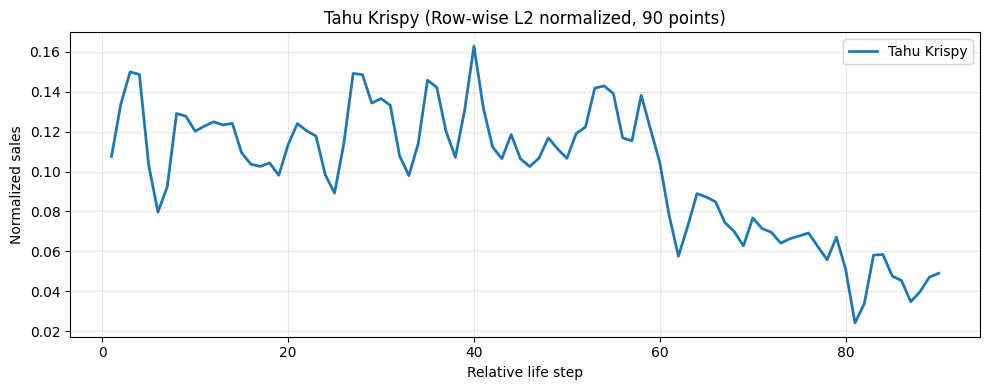

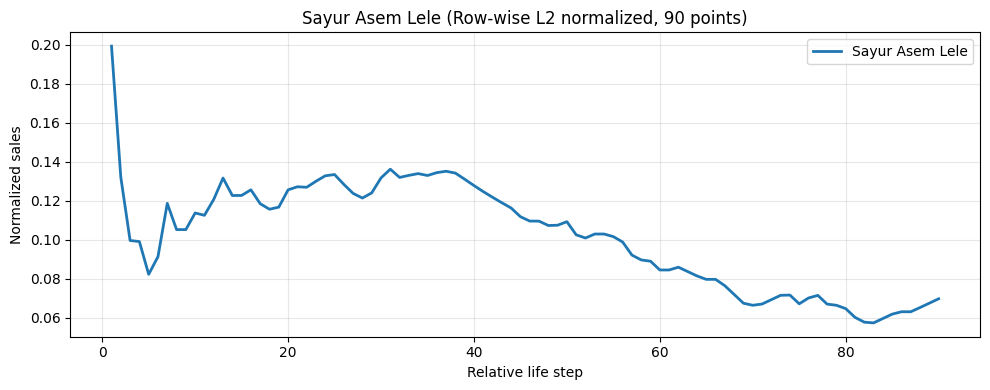

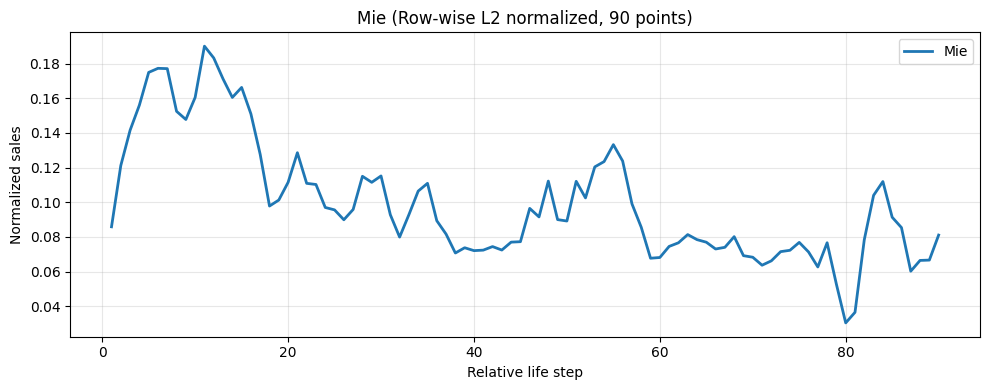

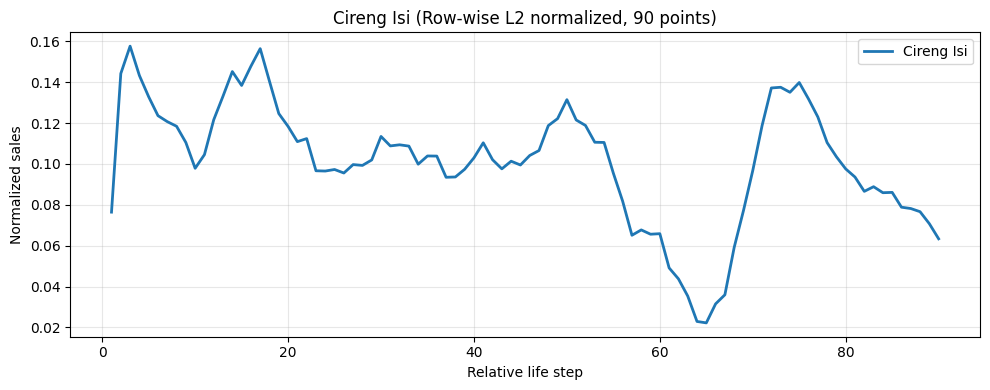

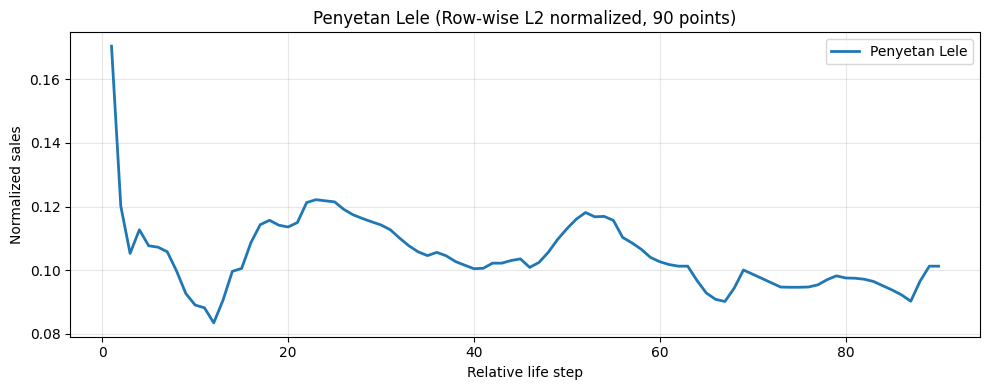

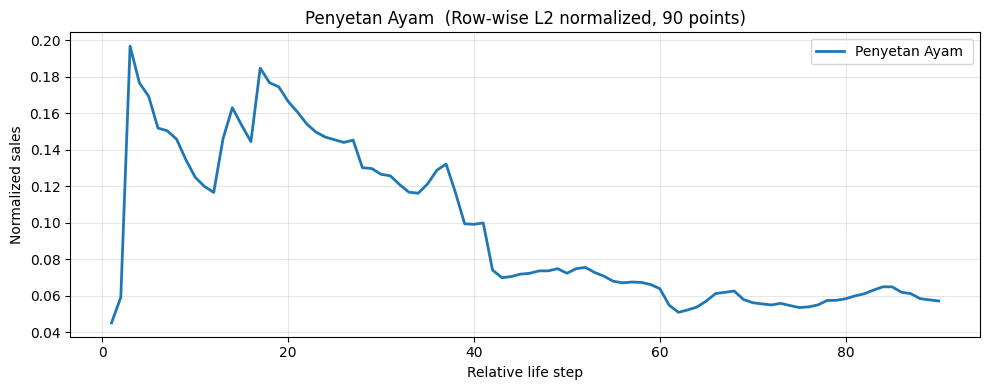

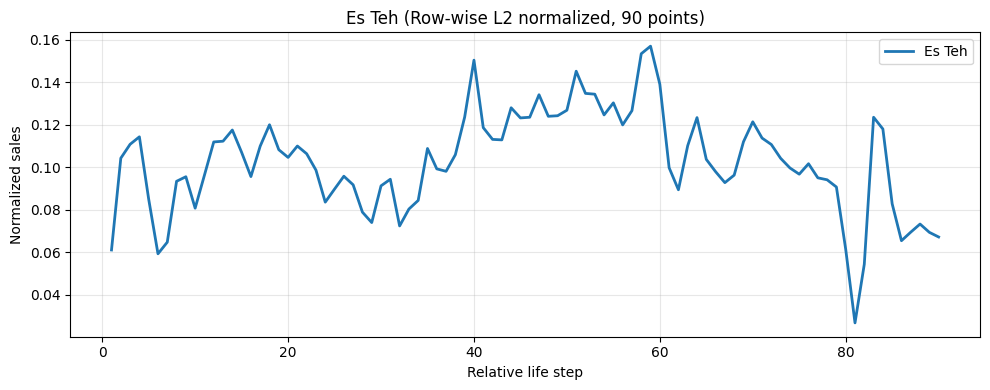

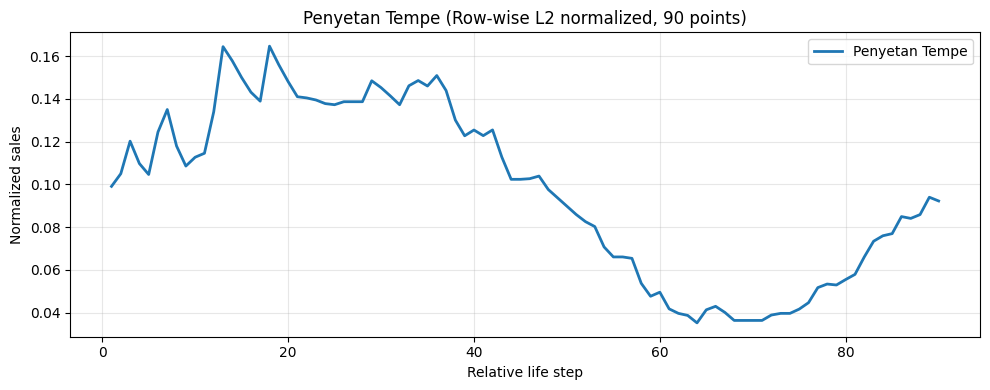

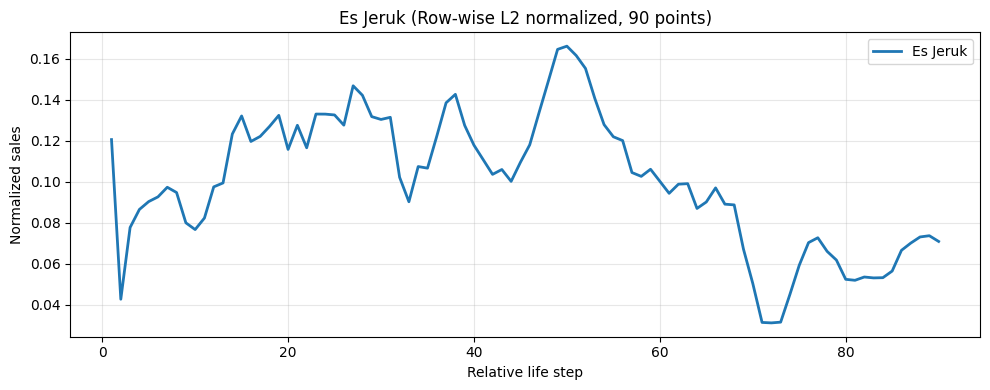

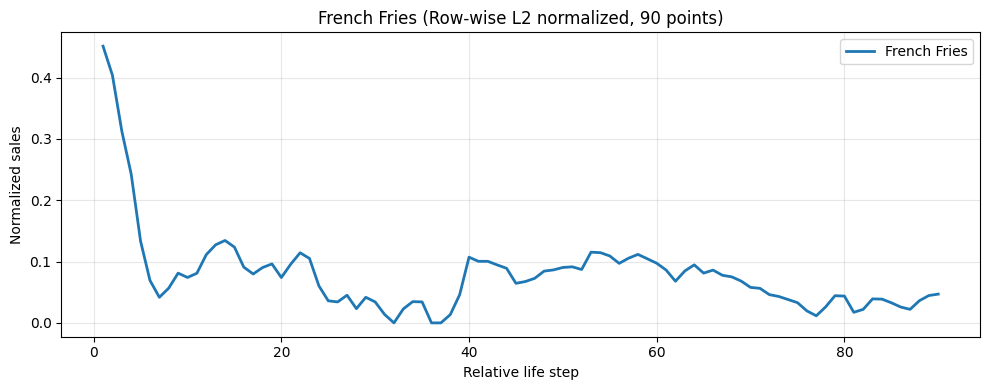

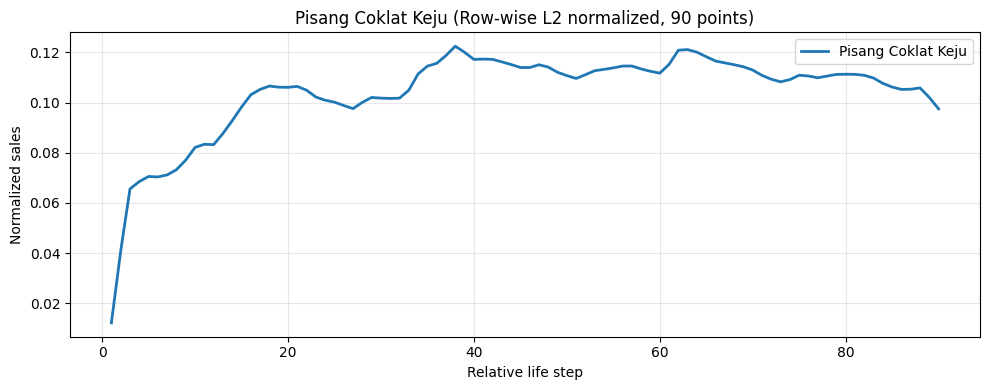

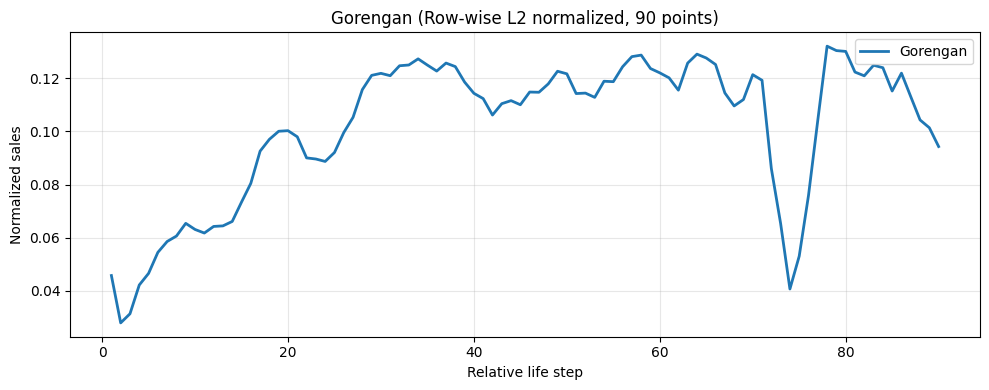

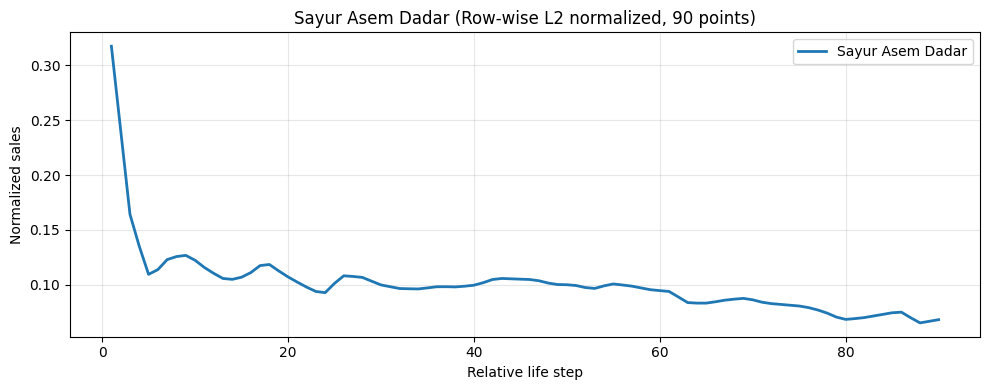

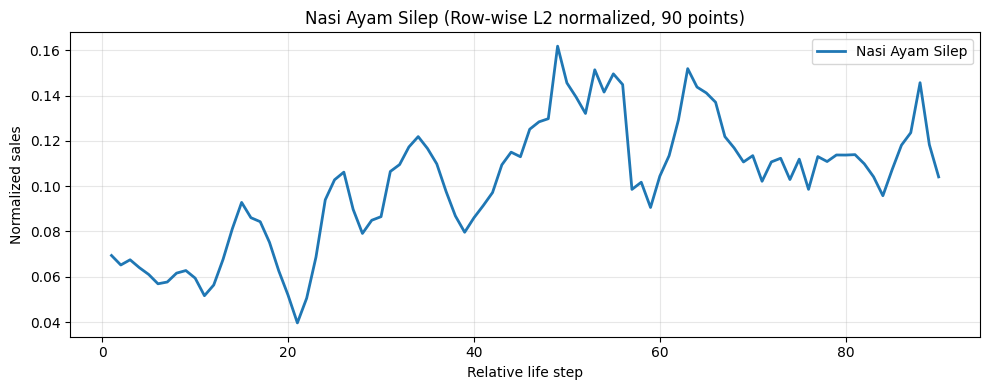

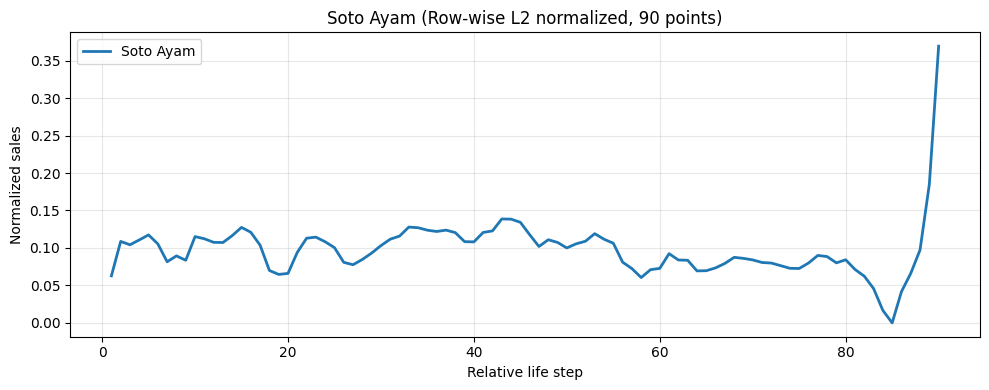

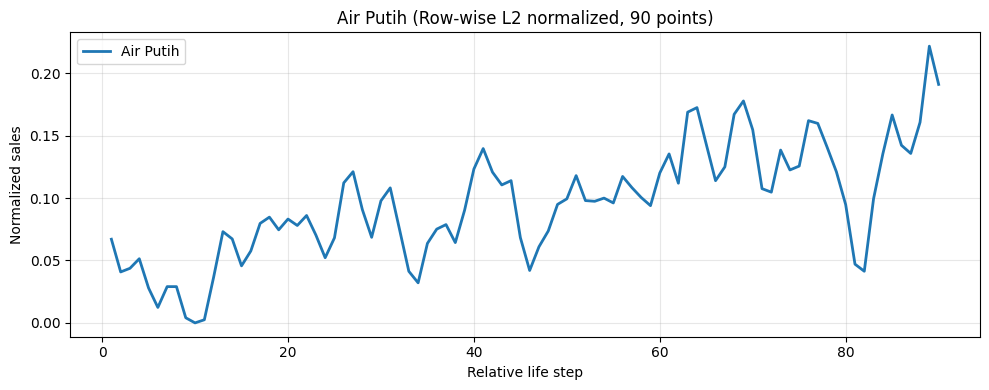

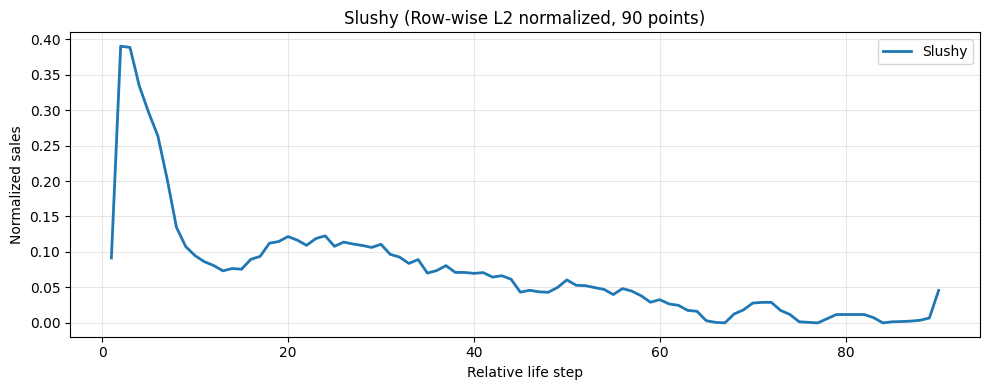

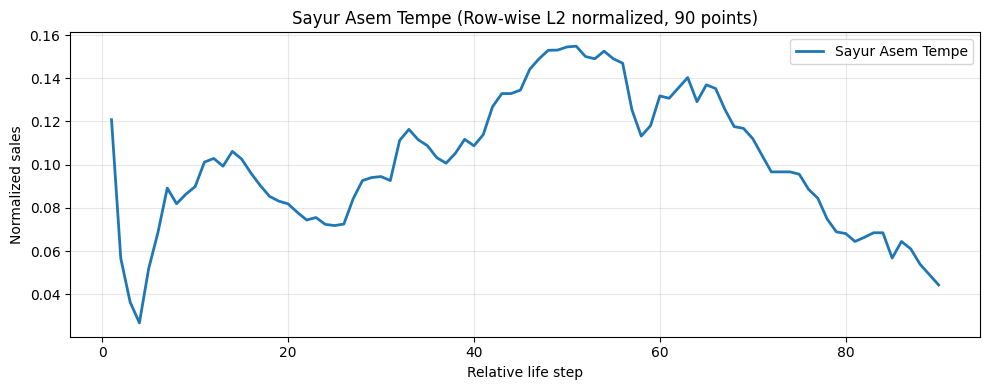

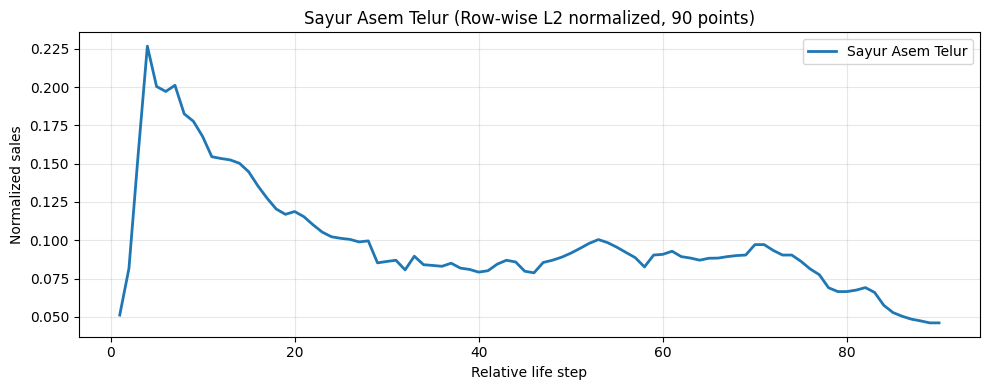

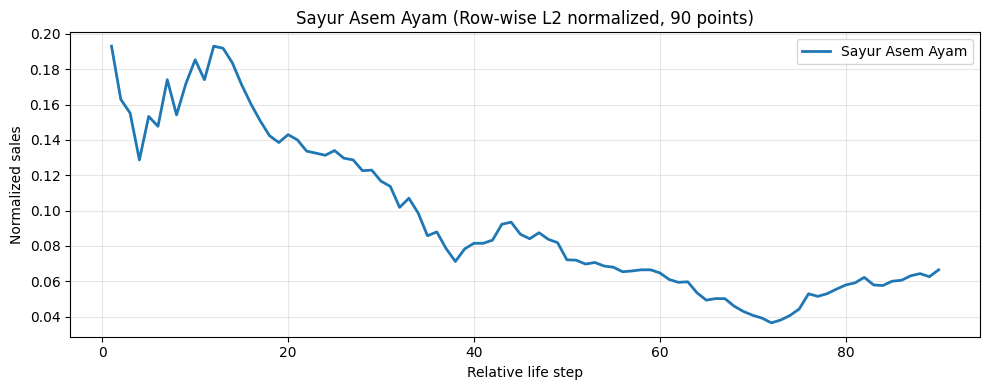

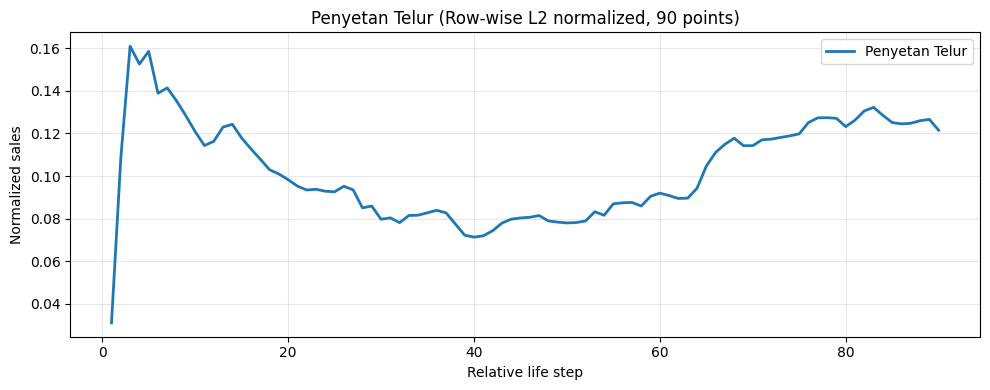

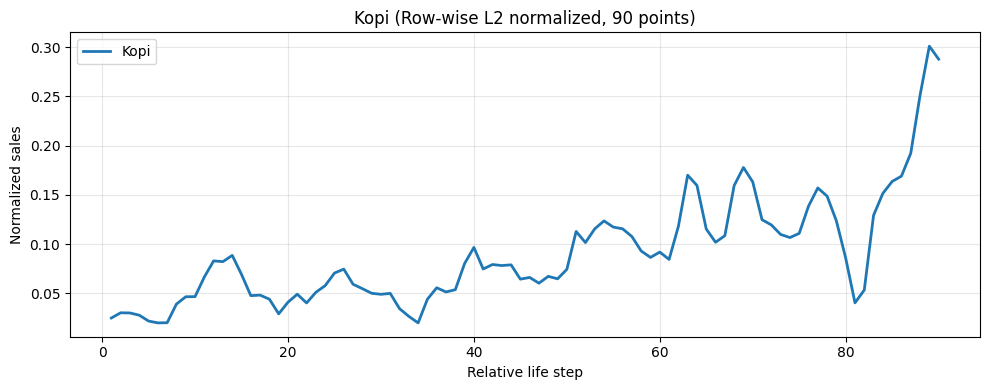

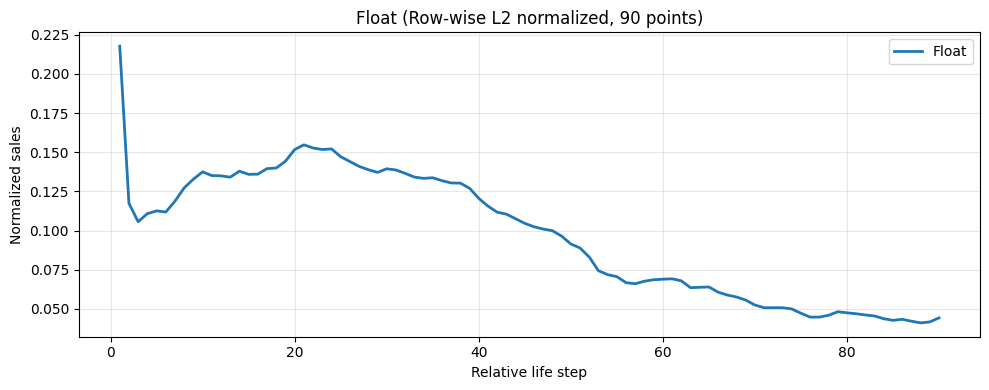

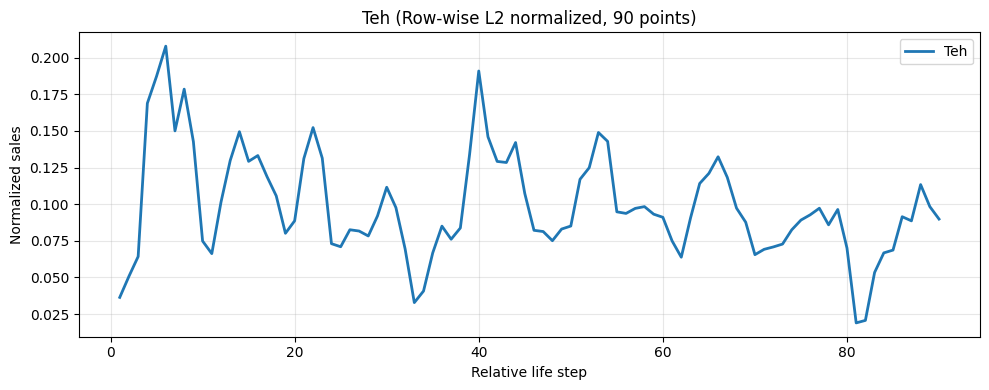

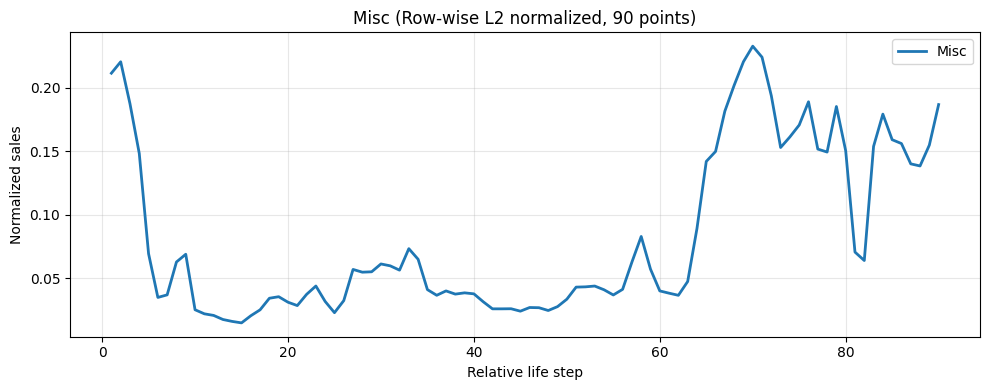

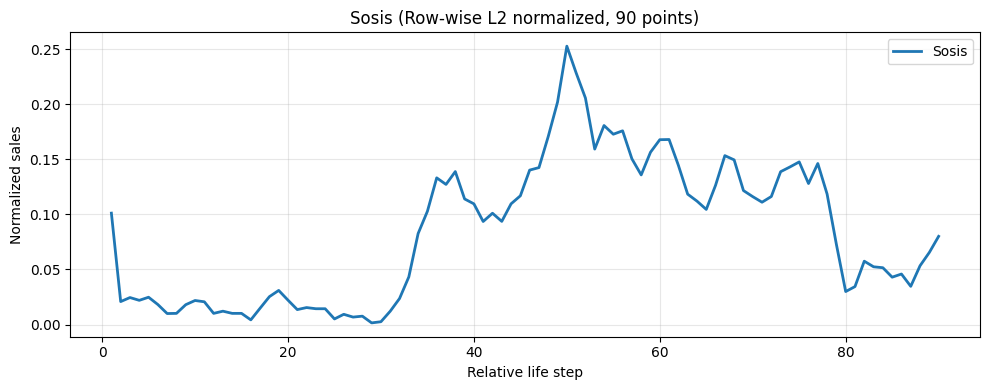

In [27]:
# --- Load resampled (rows = t1..t90, cols = items) ---
df = pd.read_csv("resampled_90points_timeseries.csv", index_col=0)

# --- L2-normalize per ITEM (row-wise on items) ---
# Work on items x time by transposing, normalize rows, then transpose back if needed
X = df.T.values                                   # shape: (n_items, L)
norms = np.linalg.norm(X, axis=1, keepdims=True)
norms[norms == 0.0] = 1.0                         # avoid divide-by-zero for all-zero items
X_unit = X / norms

# Rows = items, Cols = t1..t90 (nice for plotting by item)
df_norm_items = pd.DataFrame(X_unit, index=df.columns, columns=df.index)
df_norm_items.to_csv("resampled_90points_rowwise_normalized_items.csv")

# If you also want the original orientation (rows=time, cols=items):
df_norm_timeseries = df_norm_items.T
df_norm_timeseries.to_csv("resampled_90points_rowwise_normalized_timeseries.csv")

# --- Plot each item individually (row-wise normalized shapes) ---
L = df_norm_items.shape[1]
x = np.arange(1, L + 1)

for item in df_norm_items.index:
    y = df_norm_items.loc[item].values
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, linewidth=2, label=item)
    plt.title(f"{item} (Row-wise L2 normalized, {L} points)")
    plt.xlabel("Relative life step")
    plt.ylabel("Normalized sales")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Best k = 3 | Silhouette = 0.220


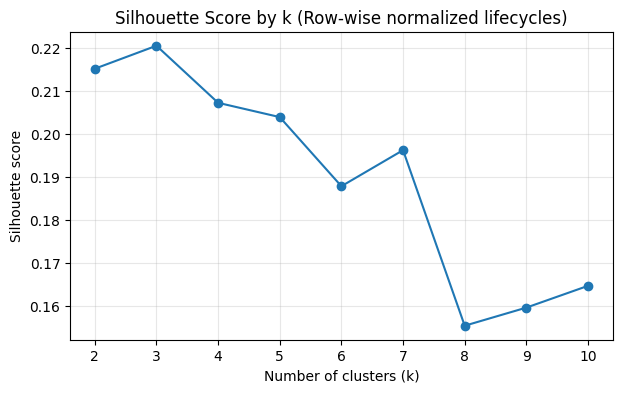

Cluster assignments saved to items_with_clusters.csv


cluster
Nasi Goreng               1
Telur Mata Sapi           0
Nasi Telur                0
Mie (Tanpa Telur)         0
Es Krim                   2
Tahu Krispy               1
Sayur Asem Lele           1
Mie                       1
Cireng Isi                1
Penyetan Lele             0
Penyetan Ayam             1
Es Teh                    0
Penyetan Tempe            1
Es Jeruk                  1
French Fries              2
Pisang Coklat Keju        0
Gorengan                  0
Sayur Asem Dadar          1
Nasi Ayam Silep           0
Soto Ayam                 0
Air Putih                 0
Slushy                    2
Sayur Asem Tempe          0
Sayur Asem Telur          1
Sayur Asem Ayam           1
Penyetan Telur            0
Kopi                      0
Float                     1
Teh                       1
Misc                      0
Sosis                     0

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# --- Use the items x 90 matrix ---
X = df_norm_items.values
item_names = df_norm_items.index

# --- Try multiple k values and compute silhouette scores ---
sil_scores = []
range_k = range(2, 11)
best_k, best_score, best_labels = None, -1, None

for k in range_k:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

    if score > best_score:
        best_k, best_score, best_labels = k, score, labels

print(f"Best k = {best_k} | Silhouette = {best_score:.3f}")

# --- Plot silhouette scores ---
plt.figure(figsize=(7,4))
plt.plot(range_k, sil_scores, marker="o")
plt.title("Silhouette Score by k (Row-wise normalized lifecycles)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(alpha=0.3)
plt.show()

# --- Assign cluster labels back to items ---
df_clusters = df_norm_items.copy()
df_clusters["cluster"] = best_labels
df_clusters.to_csv("items_with_clusters.csv")

print("Cluster assignments saved to items_with_clusters.csv")
df_clusters[["cluster"]]

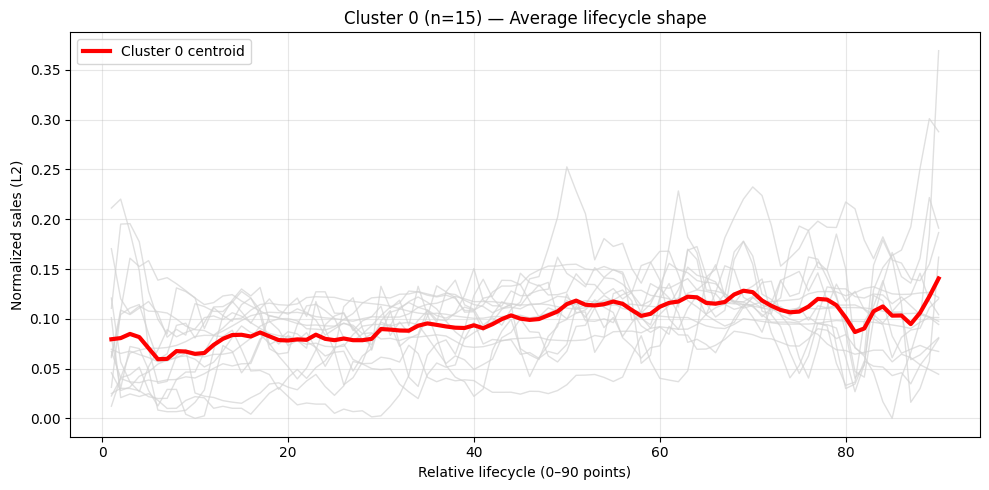

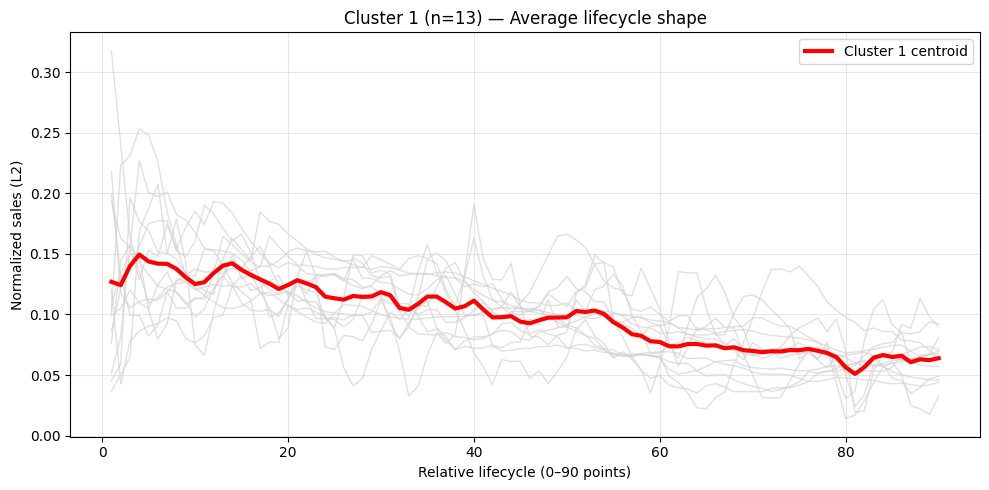

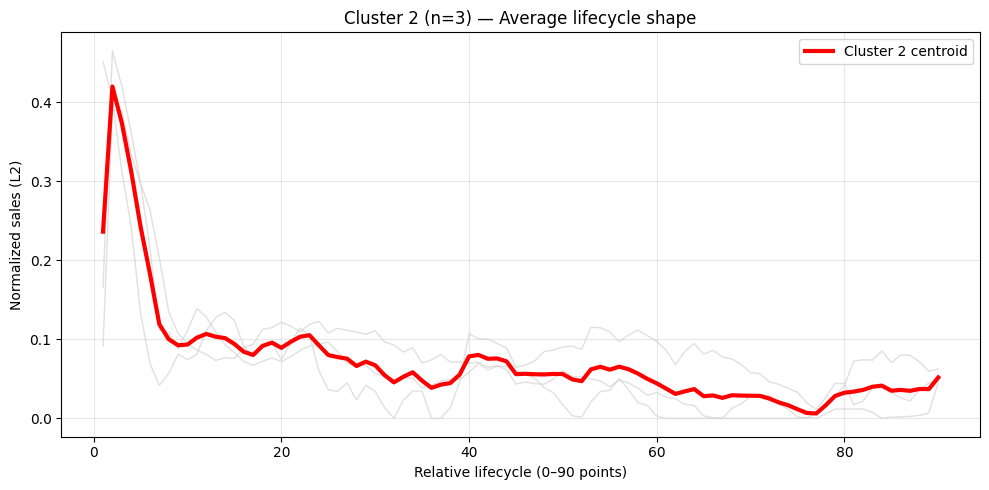

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load normalized lifecycles and cluster results ---
df_norm_items = pd.read_csv("resampled_90points_rowwise_normalized_items.csv", index_col=0)
clusters = pd.read_csv("items_with_clusters.csv", index_col=0)

# Merge cluster labels into the normalized dataframe
df_norm_items["cluster"] = clusters["cluster"]

# --- Plot each cluster ---
unique_clusters = sorted(df_norm_items["cluster"].unique())
x = np.arange(1, df_norm_items.shape[1])  # timeline (t1..t90)

for c in unique_clusters:
    cluster_data = df_norm_items[df_norm_items["cluster"] == c].iloc[:, :-1]  # drop cluster col
    centroid = cluster_data.mean(axis=0)

    plt.figure(figsize=(10, 5))
    # Plot all members in light gray
    for _, row in cluster_data.iterrows():
        plt.plot(x, row.values, color="lightgray", linewidth=1, alpha=0.7)
    # Overlay centroid
    plt.plot(x, centroid.values, color="red", linewidth=3, label=f"Cluster {c} centroid")

    plt.title(f"Cluster {c} (n={len(cluster_data)}) — Average lifecycle shape")
    plt.xlabel("Relative lifecycle (0–90 points)")
    plt.ylabel("Normalized sales (L2)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()